# Applied Data Analysis - Milestone P2

## Title : Hollywood's social structure

### Group Name : SHNO

### Project pipeline

- [Libraries](#Libraries)
- [CMU Data Importation](#CMU-Data-Importation)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Movie metadata](#Movie-metadata)
    - [Character metadata](#Character-metadata)
    - [Plot summaries](#Plot-summaries)
    - [TV Tropes](#TV-Tropes)
- [IMDb Datasets Exploratory Data Analysis](#IMDb-Datasets-Exploratory-Data-Analysis)
    - [Filtering and pre-processing the data](#Filtering-and-pre-processing-the-data)
        - [Films](#Films)
        - [Writers and directors](#Writers-and-directors)
        - [Actors](#Actors)
        - [Crew information](#title.principals.tsv.gz)
    - [Crew initial analysis](#Crew-initial-analysis)
    - [Movies initial analysis](#Movies-initial-analysis)
- [Data preprocessing](#Data-preprocessing)
    - [Outlier and missing value correction using IMDb datset values](#Outlier-and-missing-value-correction)
    - [Data preprocessing and transformation](#Methods)
    - [IMDb Dataset merging](#Methods)
    - [Build initial co-stardom graphs](#Methods)
        - [Actor-to-actor](#Methods)
        - [Movie-to-movie](#Methods)
- [Methods](#Methods)
    - [Step 1](#Step1)
    - [Step 2](#Step2)
    - [Step 3](#Step3)
    - [Step 4](#Step4)
    - [Step 5](#Step5)
    - [Step 6](#Step6)

In [1]:
# install library used to perform sentiment analysis
# !pip install vaderSentiment
# interactive graph visualization
# !pip install pyvis

## Libraries

In [1]:
# import required libraries
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import ast

# sentiment analysis
# import vaderSentiment

# graphs handling
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

# set pandas options
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

## CMU Data Importation

In [2]:
# set data paths
DATA_FOLDER = 'data/MovieSummaries/'

CHARACTER_META = DATA_FOLDER+'character.metadata.tsv'
MOVIE_META = DATA_FOLDER+'movie.metadata.tsv'
NAME_CLUSTERS = DATA_FOLDER+'name.clusters.txt'
PLOT_SUMM = DATA_FOLDER+'plot_summaries.txt'
TV_TROPES = DATA_FOLDER+'tvtropes.clusters.txt'

In [3]:
# load movies metadata
movie_meta = pd.read_csv(MOVIE_META, sep='\t', header=None)

movie_meta.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue',
                     'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']

# load characters metadata
character_meta = pd.read_csv(CHARACTER_META, sep='\t', header=None)
character_meta.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date' ,'character_name', 'actor_date_of_birth', 'actor_gender',
                    'actor_height_m', 'actor_ethnicity_id', 'actor_name', 'actor_age_at_movie_release', 'freebase_character/actor_map_id',
                    'freebase_character_id', 'freebase_actor_id']

# load charcter name clusters
name_clusters = pd.read_csv(NAME_CLUSTERS, sep='\t', header=None)
name_clusters.columns = ['character_name', 'freebase_character/actor_map_id']

# load plot summaries
plot_summ = pd.read_csv(PLOT_SUMM, sep='\t', header=None)
plot_summ.columns = ['wikipedia_movie_id', 'summary']

# load tv tropes
tv_tropes = pd.read_csv(TV_TROPES, sep='\t', header=None)
tv_tropes.columns = ['character_type', 'freebase_character/actor_map_id']

## Exploratory Data Analysis

### CMU Datasets

The data is separated in n different files namely **plot_summaries**, **movie.metadata**, **character.metadata**, **tvtropes.clusters** and **name.clusters**. We will explore the files individually before merging the relevant features on two different dataframes : the first will be movie-centric indexed by movie_id, the second will be cast centered and indexed by the actor_id. This manipulation will ease the construction of graphs involving movie to movie, actor to movie, actor to movie graphs on which we will perform an extensive network analysis.

#### Movie metadata

The movie metadata file is extracted in a dataframe with the following attributes :  

`wikipedia_movie_id`:  wikidata movie id  (str)  
`freebase_movie_id`:  freebase movie id  (str)  
`movie_name`:  movie name ()  
`release_date`:  unformated release date of the movie  ()    
`movie_revenue`:  box office revenue ()  
`runtime`:   movie runtime ()  
`languages`:  movie languages (freebase id name tuples)  
`countries`:  movie countries release (freebase id name tuples)  
`genres`:  movie genres (freebase id name tuples) 

In [4]:
movie_meta.head(1)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"


We compute the ratio of missing values per attribute to see which feature are usable or not for our analysis. We can see that almost 90% of the movie revenue attribute is missing, therefore we will drop this column (maybe try to fill this attribute with IMDb datasets).

In [5]:
# display null values for every column
(movie_meta.isna().sum()/len(movie_meta))*100

wikipedia_movie_id           0.000000
freebase_movie_id            0.000000
movie_name                   0.000000
movie_release_date           8.443743
movie_box_office_revenue    89.722416
movie_runtime               25.018045
movie_languages              0.000000
movie_countries              0.000000
movie_genres                 0.000000
dtype: float64

The next lines prove us that the wikipedia_movie_id and freebase_movie_id can both be used as an index, and that this dataframe contains no duplicates.

In [6]:
# compute number of movies (distinct IDs)
n_wiki_movies = movie_meta['wikipedia_movie_id'].nunique()
n_freebase_id = movie_meta['freebase_movie_id'].nunique()

assert(len(movie_meta) == n_wiki_movies)
assert(n_wiki_movies == n_freebase_id)

print(f'There are {n_wiki_movies} movies in the CMU database')

There are 81741 movies in the CMU database


We then need to convert to format the release date attribute into a dedicated datetime object to ease future computations. 

In [7]:
# convert dates into date format
movie_meta['movie_release_date_formatted'] = pd.to_datetime(movie_meta['movie_release_date'], errors='coerce').apply(lambda x: x.date())
movie_meta.dtypes

wikipedia_movie_id                int64
freebase_movie_id                object
movie_name                       object
movie_release_date               object
movie_box_office_revenue        float64
movie_runtime                   float64
movie_languages                  object
movie_countries                  object
movie_genres                     object
movie_release_date_formatted     object
dtype: object

We have to check the instances where the movie year is invalid, and then manually correct it if possible. We are lucky, there is only one instance of such case.

In [8]:
# display instances in which movie year is invalid
movie_meta[movie_meta['movie_release_date_formatted'].isnull() & ~(movie_meta['movie_release_date'].isnull())]

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_date_formatted
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc"": ""English Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""Mystery"", ""/m/07s9rl0"": ""Drama"", ""/m/01jfsb"": ""Thriller""}",NaT


In [9]:
# correct invalid release dates
movie_meta.loc[movie_meta['wikipedia_movie_id'] == 29666067, 'movie_release_date_formatted'] = date(2010, 12, 2)
assert 0 == len(movie_meta[movie_meta['movie_release_date_formatted'].isnull() & ~(movie_meta['movie_release_date'].isnull())])

In [10]:
# corrected data
movie_meta[movie_meta['wikipedia_movie_id'] == 29666067]

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_date_formatted
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc"": ""English Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""Mystery"", ""/m/07s9rl0"": ""Drama"", ""/m/01jfsb"": ""Thriller""}",2010-12-02


In [11]:
# update original column
movie_meta['movie_release_date'] = movie_meta['movie_release_date_formatted']
del movie_meta['movie_release_date_formatted']
# save year
movie_meta['movie_release_year'] = movie_meta['movie_release_date'].apply(lambda x: x.year)

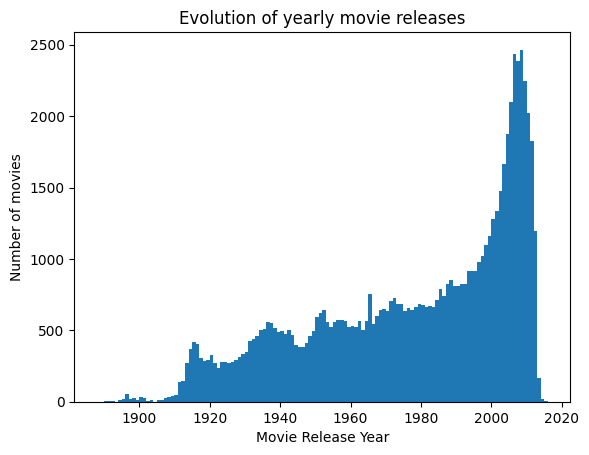

In [12]:
n_bins = int(movie_meta['movie_release_year'].dropna().max() - movie_meta['movie_release_year'].dropna().min())
movie_meta['movie_release_year'].plot.hist(bins=n_bins)

plt.xlabel('Movie Release Year')
plt.ylabel('Number of movies')
plt.title('Evolution of yearly movie releases')
plt.show()

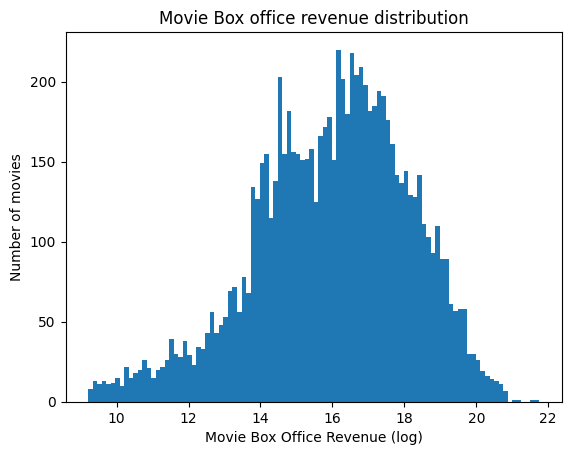

In [13]:
np.log(movie_meta['movie_box_office_revenue']).plot.hist(bins=100)

plt.xlabel('Movie Box Office Revenue (log)')
plt.ylabel('Number of movies')
plt.title('Movie Box office revenue distribution')
plt.show()

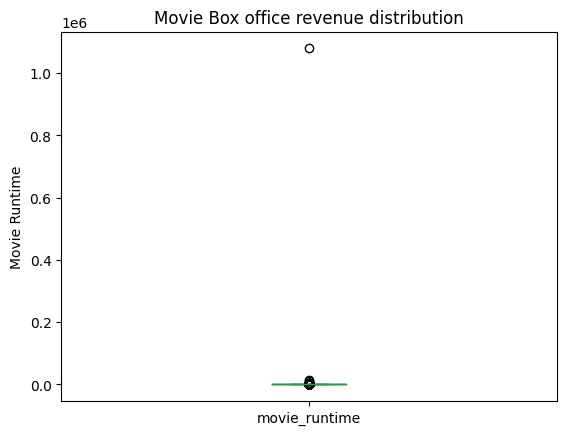

0     98.0
1     95.0
2     83.0
3    110.0
4    106.0
Name: movie_runtime, dtype: float64

In [14]:
# Distribution of movie runtime
movie_meta['movie_runtime'].plot.box()

plt.ylabel('Movie Runtime')
plt.title('Movie Box office revenue distribution')
plt.show()
movie_meta['movie_runtime'].head()

In [15]:
# Display outliers
movie_meta.sort_values(by='movie_runtime', ascending=False).head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
12804,10815585,/m/02qqy23,Zero Tolerance,1995-01-01,NaN,1079281.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/0219x_"": ""Indie"", ""/m/03btsm8"": ""Action/Adventure""}",1995.0
62962,32441022,/m/0gyr803,Modern Times Forever,NaT,NaN,14400.0,{},{},"{""/m/0jtdp"": ""Documentary""}",NaN
71100,25345684,/m/09gqhh3,Cinématon,2011-01-01,NaN,9360.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/0424mc"": ""Experimental film"", ""/m/0jtdp"": ""Documentary""}",2011.0
21733,14545195,/m/03qcghh,Matrjoschka,2006-04-23,NaN,5700.0,{},"{""/m/0345h"": ""Germany""}","{""/m/0219x_"": ""Indie"", ""/m/0jtdp"": ""Documentary""}",2006.0
46666,884435,/m/03lmv2,The Cure for Insomnia,1987-01-31,NaN,5220.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4lw"": ""Art film""}",1987.0


To fix outliers and missing values, we plan to use the imdb dataset to find if we can extract the values from it.

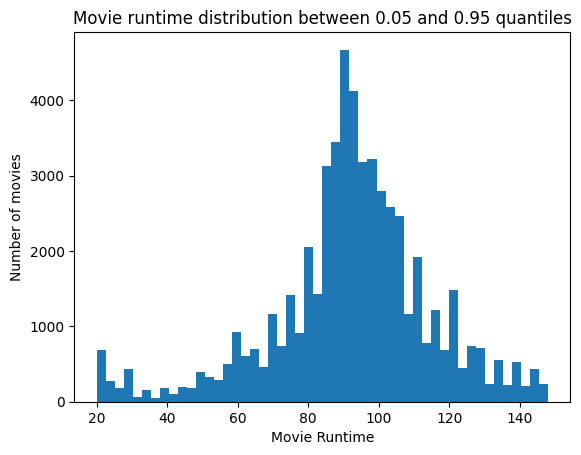

In [16]:
# Distribution of movie runtime
# We display values between 0.05 and 0.95 quantiles as we will fix the outliers with the imdb dataset
display_range = (movie_meta['movie_runtime'].quantile(0.05), movie_meta['movie_runtime'].quantile(0.95))
movie_meta['movie_runtime'].plot.hist(bins=50, range=display_range)

plt.xlabel('Movie Runtime')
plt.ylabel('Number of movies')
plt.title('Movie runtime distribution between 0.05 and 0.95 quantiles')
plt.show()

In [17]:
test_meta = movie_meta

In [18]:
test_meta.loc[:, 'movie_languages_ids'] = test_meta['movie_languages'].apply(lambda x: ast.literal_eval(x).values())
test_meta.loc[:, 'movie_countries_ids'] = test_meta['movie_countries'].apply(lambda x: ast.literal_eval(x).values())
test_meta.loc[:, 'movie_genres_ids'] = test_meta['movie_genres'].apply(lambda x: ast.literal_eval(x).values())

In [19]:
language_ids = pd.Series([language for languages in test_meta['movie_languages_ids'] for language in languages])
language_counts = language_ids.value_counts()[:10]

country_ids = pd.Series([country for countries in test_meta['movie_countries_ids'] for country in countries])
country_counts = country_ids.value_counts()[:10]

genre_ids = pd.Series([genre for genres in test_meta['movie_genres_ids'] for genre in genres])
genre_counts = genre_ids.value_counts()[:10]

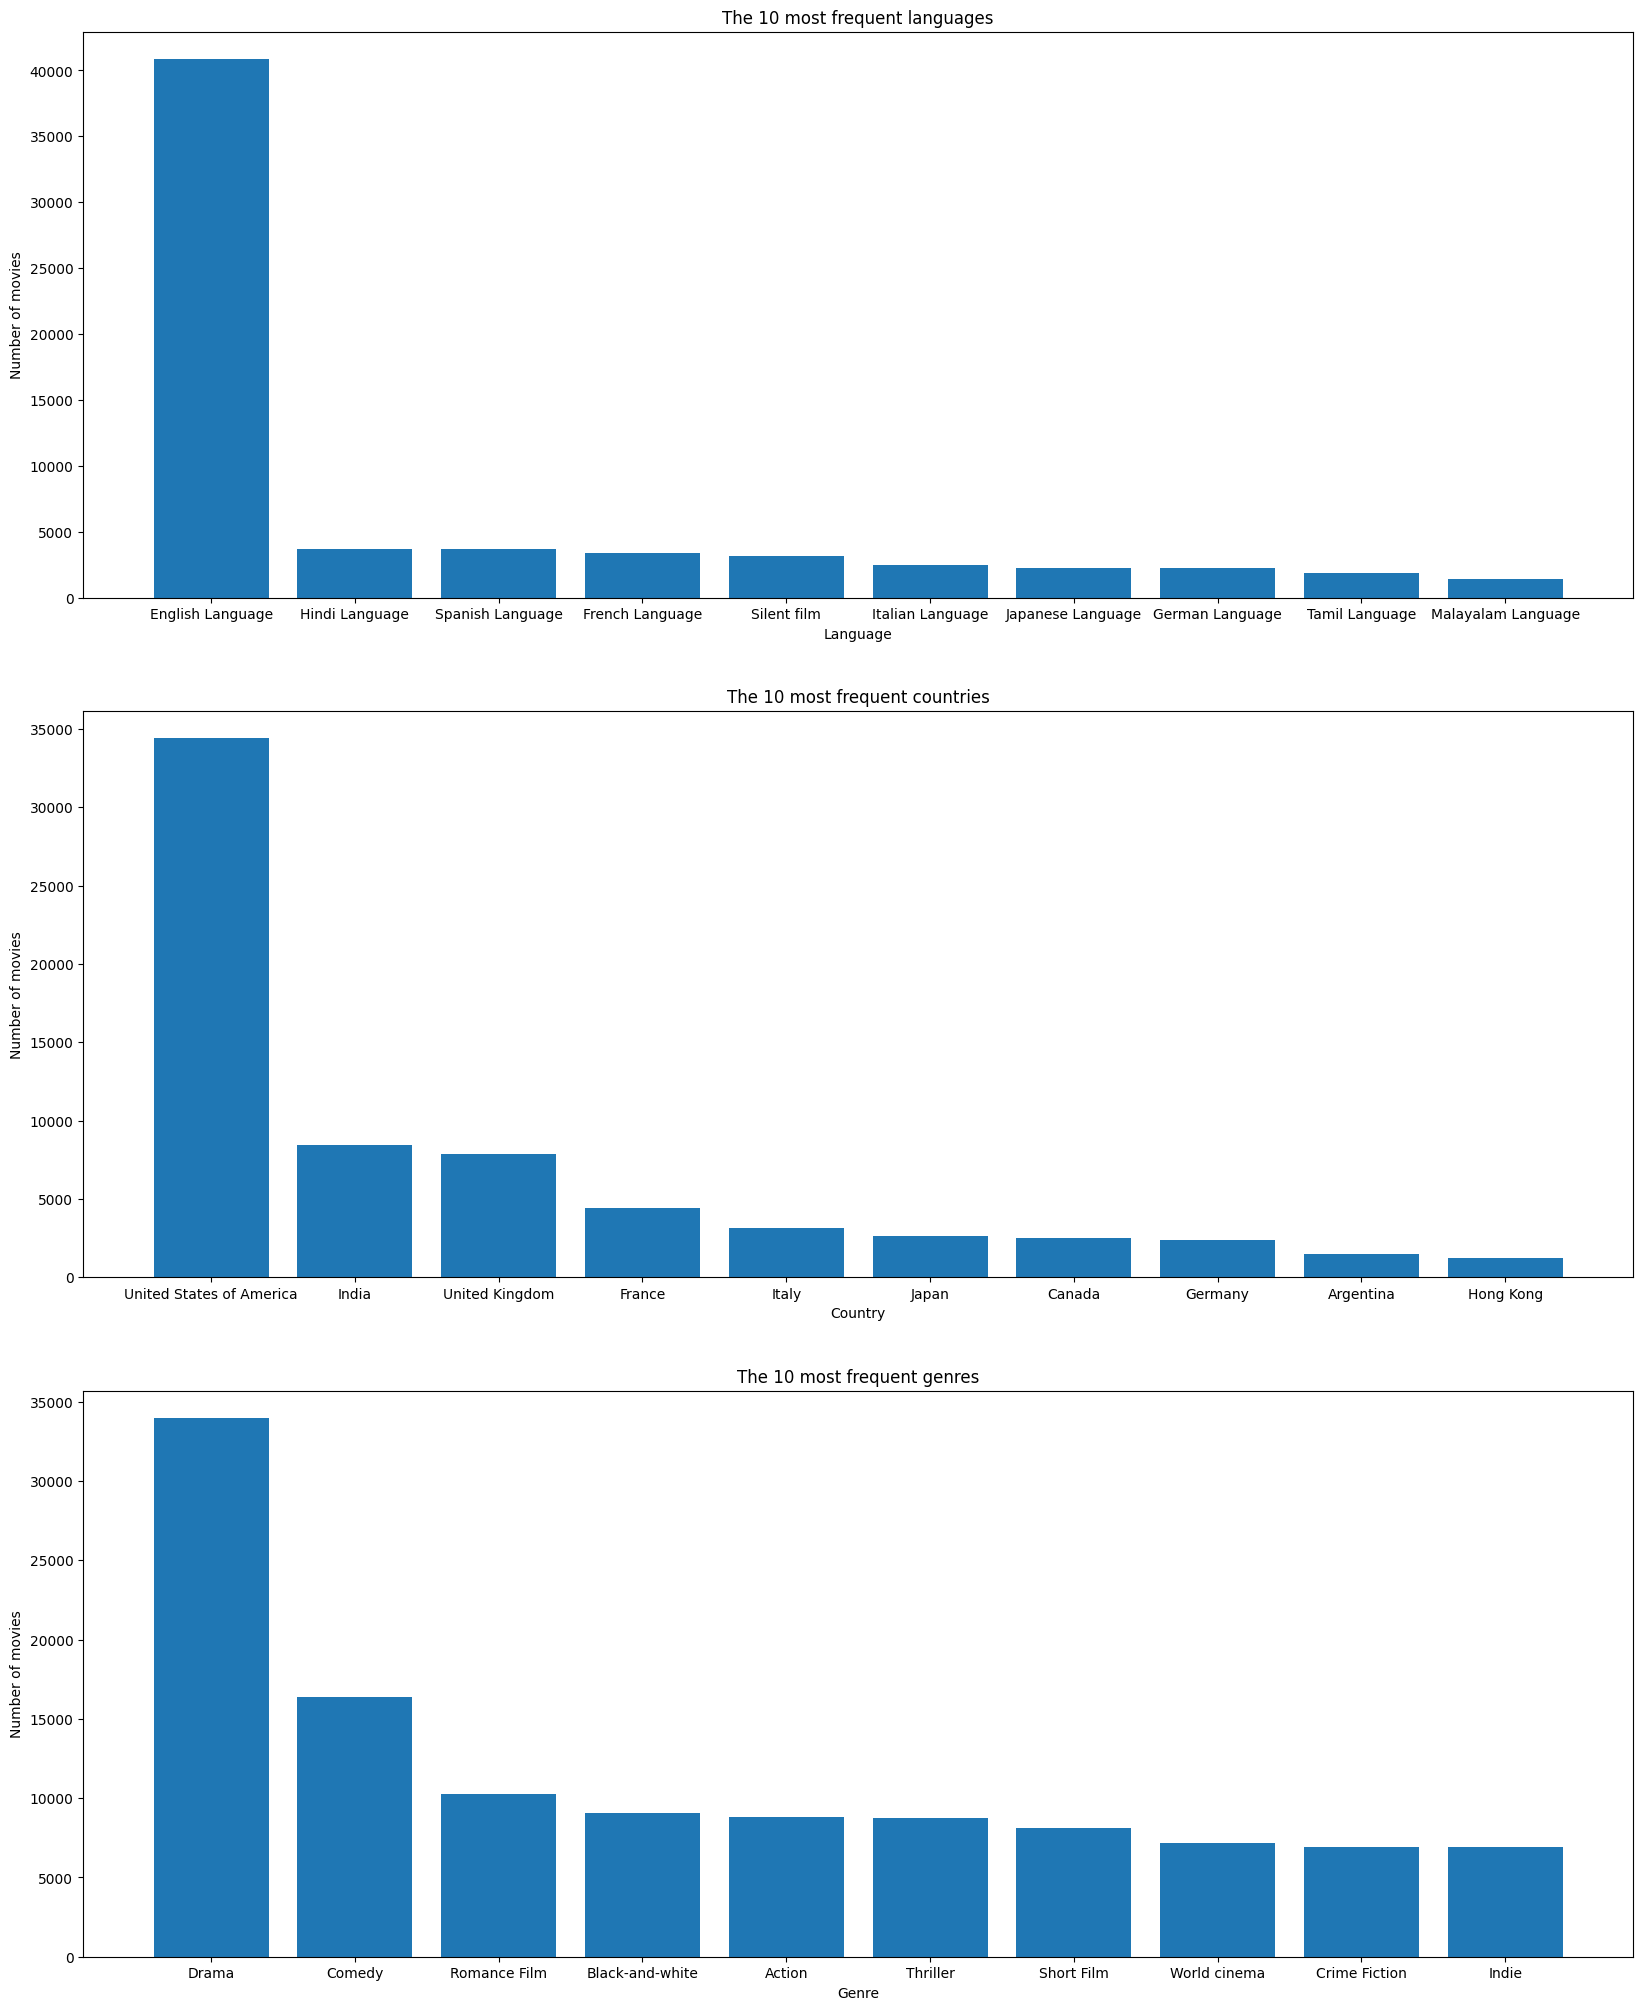

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20, 25))
ax1.bar(x=language_counts.index, height=language_counts.values)
ax1.set_xlabel('Language')
ax1.set_ylabel('Number of movies')
ax1.set_title('The 10 most frequent languages')

ax2.bar(x=country_counts.index, height=country_counts.values)
ax2.set_xlabel('Country')
ax2.set_ylabel('Number of movies')
ax2.set_title('The 10 most frequent countries')

ax3.bar(x=genre_counts.index, height=genre_counts.values)
ax3.set_xlabel('Genre')
ax3.set_ylabel('Number of movies')
ax3.set_title('The 10 most frequent genres')

plt.show()

#### Plot summaries

The plot summary file is extracted in a dataframe with the following attributes :

`wikipedia_movie_id`:  wikidata movie id  (str)    
`plot_summary`:  wikidata plot summary of the movie  (str) 

In [21]:
plot_summ.head(1)

,wikipedia_movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."


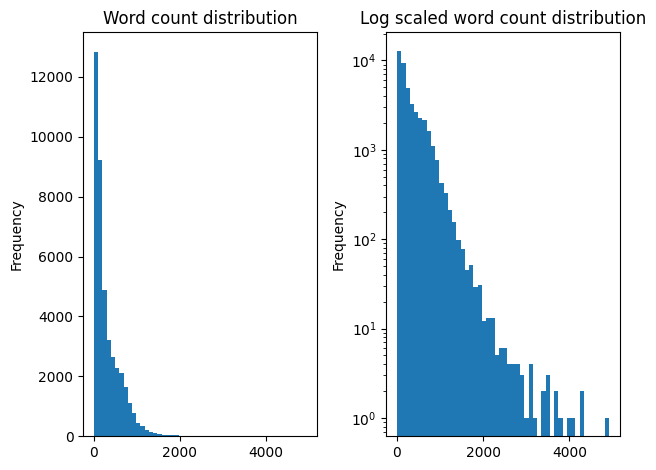

In [22]:
# Using trivial tokenizer
plot_summ['count'] = plot_summ['summary'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(nrows=1, ncols=2)
plot_summ['count'].plot(kind='hist', ax = axes[0], bins=50)
plot_summ['count'].plot(kind='hist', logy=True, bins=50, ax=axes[1])
#plt.suptitle('Plot summary word count distribution', x=0.5, y=1.05, ha='center', fontsize='xx-large')
axes[0].title.set_text('Word count distribution')
axes[1].title.set_text('Log scaled word count distribution')
fig.tight_layout()

We can merge the two previous datasets namely containing namely plot_summary and movie_metadata information into a single dataframe. Unfortunately, the plot_summary dataframe contains the summary of 42303 movies far from the 81741 movies described in the movie_metadata dataframe. The intersection of the dataframes on movie_id yields 42204 collisions, meaning that 99 summaries were not matched with a movie. We will thus keep it as a separate dataframe in case we need it.

In [23]:
merged = pd.merge(movie_meta, plot_summ, left_on='wikipedia_movie_id', right_on='wikipedia_movie_id')

merged.index = merged.wikipedia_movie_id
merged = merged.drop(columns=['wikipedia_movie_id']).sort_values(by='wikipedia_movie_id')
merged.head(1)

,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,movie_languages_ids,movie_countries_ids,movie_genres_ids,summary,count
wikipedia_movie_id,,,,,,,,,,,,,,
330,/m/0ktn59,Actrius,1996-01-01,NaN,90.0,"{""/m/01m69"": ""Catalan language"", ""/m/06nm1"": ""Spanish Language""}","{""/m/06mkj"": ""Spain""}","{""/m/07s9rl0"": ""Drama"", ""/m/01t_vv"": ""Comedy-drama""}",1996.0,"(Catalan language, Spanish Language)",(Spain),"(Drama, Comedy-drama)","In order to prepare the role of an important old actress, a theatre student interviews three actresses who were her pupils: an international diva , a television star and a dubbing director .",33


#### Character metadata

The character metadata file is extracted in a dataframe with the following attributes :

`wikipedia_movie_id`:  wikidata movie id  ()  
`freebase_movie_id`:  freebase movie id  ()  
`release_date`:  unformated release date of the movie  ()   
`character_name`:  character name  ()  
`actor_date_of_birth`:  actor date of birth ()  
`actor_gender`:  actor gender (str)  
`actor_height`:  actor height ()  
`actor_ethnicity`: actor ethnicity specified with a freebase id   
`actor_name`:  actor name  ()  
`actor_age_movie_release`:  actor age at movie release date ()  
`freebase_character_to_actor`:   mapping from character freebase id to actor id ()  
`freebase_character_id`:  character freebase id ()  
`freebase_actor_id`:  actor freebase id ()

In [24]:
character_meta.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height_m,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character/actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


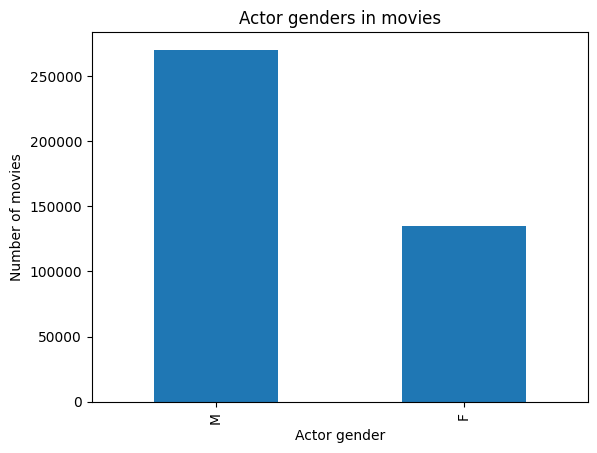

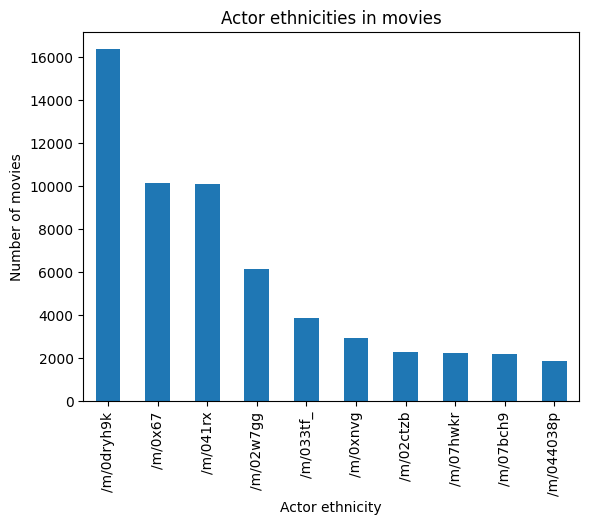

In [25]:
character_meta['actor_gender'].value_counts().plot.bar()
plt.xlabel('Actor gender')
plt.ylabel('Number of movies')
plt.title('Actor genders in movies')
plt.show()
character_meta['actor_ethnicity_id'].value_counts()[:10].plot.bar()
plt.xlabel('Actor ethnicity')
plt.ylabel('Number of movies')
plt.title('Actor ethnicities in movies')
plt.show()

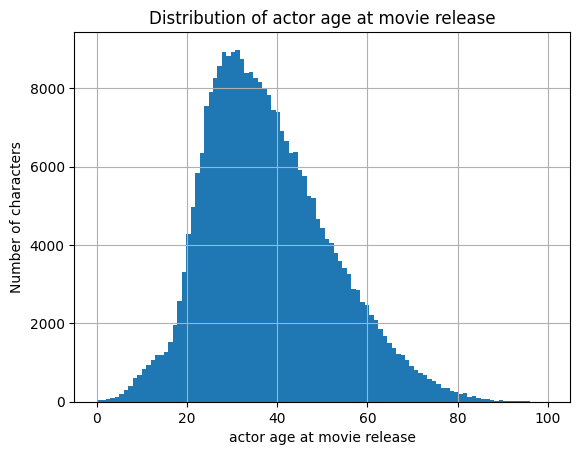

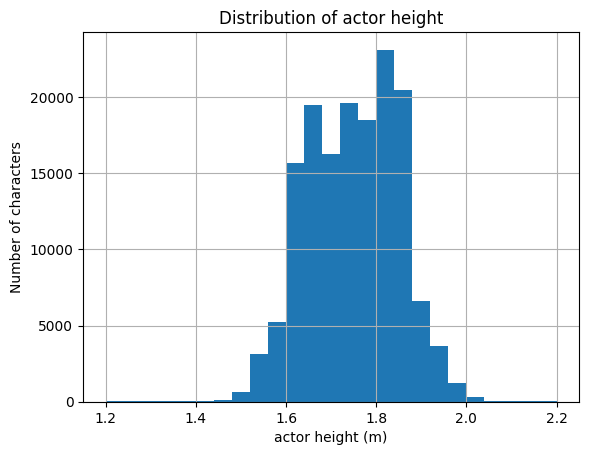

In [26]:
character_meta['actor_age_at_movie_release'].hist(bins=101, range=(0, 100))
plt.xlabel('actor age at movie release')
plt.ylabel('Number of characters')
plt.title('Distribution of actor age at movie release')
plt.show()
character_meta['actor_height_m'].hist(bins=25, range=(1.2, 2.2))
plt.xlabel('actor height (m)')
plt.ylabel('Number of characters')
plt.title('Distribution of actor height')
plt.show()

In [27]:
name_clusters.head()

,character_name,freebase_character/actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [28]:
name_clusters.nunique()

character_name                      970
freebase_character/actor_map_id    2661
dtype: int64

#### TV Tropes

The tv tropes file is extracted in a dataframe with the following attributes :

`character_type`:  short description of the character type (str)    
`freebase_character/actor_map_id`:  dictionnary containing character name, movie name, actor name and actor map id  (dict) 

In [29]:
tv_tropes.head()

,character_type,freebase_character/actor_map_id
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"": ""Flubber"", ""id"": ""/m/0jy9q0"", ""actor"": ""Robin Williams""}"
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richie Rich"", ""id"": ""/m/02vchl3"", ""actor"": ""Michael McShane""}"
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The Shadow"", ""id"": ""/m/0k6fkc"", ""actor"": ""Ian McKellen""}"
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!"", ""id"": ""/m/0k6_br"", ""actor"": ""Edmund Gwenn""}"
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate"", ""id"": ""/m/0k3rhh"", ""actor"": ""James Spader""}"


In [30]:
tv_tropes.nunique()

character_type                      72
freebase_character/actor_map_id    447
dtype: int64

As stated in the paper presenting the CMU datasets, there are 72 character/tv tropes types.  
Our next task is to combine the last three datasets into a single dataframe that will contain character/actor information : we can make use of the 'id' attribute inside the 'freebase_character/actor_map_id' column to merge this dataframe with the character dataframe.

### Character Tropes Analysis

For this study, we will only keep actors that have a non-null character type defined in the tv tropes dataframe. Then, we will apply a 2D principal components analysis to visualize the actors/actresses on a lower dimensional plan and measure how close they are. We will also visualize a co-stardom graph of the actor that possess a character trope.

In [31]:
import json

tv_tropes['map_id'] = tv_tropes['freebase_character/actor_map_id'].apply(lambda x: (json.loads(x)['id']))
character_meta = character_meta.rename(columns={'freebase_character/actor_map_id': "map_id"})

In [32]:
character_meta

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height_m,actor_ethnicity_id,actor_name,actor_age_at_movie_release,map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


#### Merging with characters and tv tropes

In [33]:
character_meta_merged = character_meta.merge(tv_tropes, on='map_id')

In [34]:
character_meta_merged = character_meta_merged.drop(columns=['freebase_character/actor_map_id'])

In [35]:
character_meta_merged.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height_m,actor_ethnicity_id,actor_name,actor_age_at_movie_release,map_id,freebase_character_id,freebase_actor_id,character_type
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury
1,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,granola_person
2,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,playful_hacker
3,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,charmer
4,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,loveable_rogue


In [36]:
character_meta_merged[character_meta_merged['character_type'].notnull()].head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height_m,actor_ethnicity_id,actor_name,actor_age_at_movie_release,map_id,freebase_character_id,freebase_actor_id,character_type
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury
1,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,granola_person
2,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,playful_hacker
3,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,charmer
4,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,loveable_rogue


In [37]:
character_meta_merged.freebase_actor_id.nunique()

350

In [38]:
character_meta_merged['character_type'].nunique()

72

In [39]:
# histograms of character type frequencies on available data

In [40]:
'''fig, ax = plt.subplots(figsize = (32, 11))
y_pos = np.arange(len(character_grouped.index))
ax.barh(y_pos, character_grouped.freebase_actor_id, align='center')
ax.set_yticks(y_pos, labels=character_grouped.index)
ax.set_xlabel('Frequency')
ax.set_title('Character type frequency')

plt.show()'''

"fig, ax = plt.subplots(figsize = (32, 11))\ny_pos = np.arange(len(character_grouped.index))\nax.barh(y_pos, character_grouped.freebase_actor_id, align='center')\nax.set_yticks(y_pos, labels=character_grouped.index)\nax.set_xlabel('Frequency')\nax.set_title('Character type frequency')\n\nplt.show()"

<AxesSubplot: >

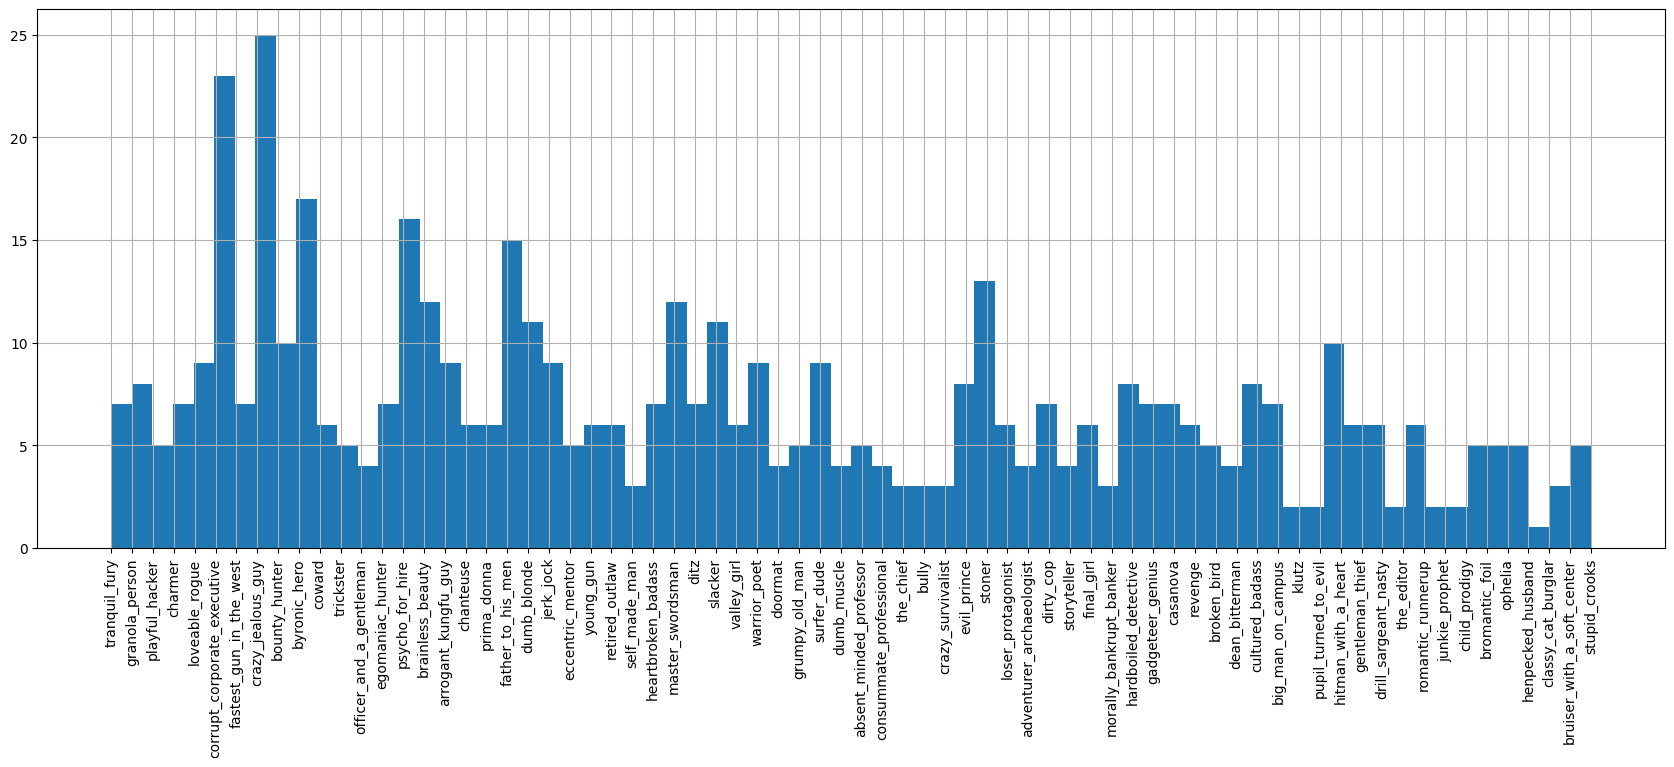

In [314]:
character_meta_merged['character_type'].hist(xrot=90, 
                                             bins=character_meta_merged['character_type'].nunique(), 
                                             figsize=(21, 7))

In [315]:
# save bar plot in 

<Figure size 640x480 with 0 Axes>

#### Merging characters and movie 

In [42]:
character_meta_movie = character_meta_merged.merge(movie_meta, on='freebase_movie_id')

In [43]:
character_meta_movie = character_meta_movie.drop(columns=['movie_languages', 'movie_countries', 'movie_genres'])

In [44]:
list(character_meta_movie['movie_genres_ids'][0])

['Thriller', 'Drama']

In [45]:
character_meta_movie.head()

,wikipedia_movie_id_x,freebase_movie_id,movie_release_date_x,character_name,actor_date_of_birth,actor_gender,actor_height_m,actor_ethnicity_id,actor_name,actor_age_at_movie_release,...,character_type,wikipedia_movie_id_y,movie_name,movie_release_date_y,movie_box_office_revenue,movie_runtime,movie_release_year,movie_languages_ids,movie_countries_ids,movie_genres_ids
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,...,tranquil_fury,196176,Straw Dogs,1971-11-03,11148828.0,118.0,1971.0,(English Language),"(United States of America, United Kingdom)","(Thriller, Drama)"
1,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,...,granola_person,1157158,Death to Smoochy,2002-03-29,8382938.0,109.0,2002.0,(English Language),"(United States of America, United Kingdom, Germany)","(Parody, Black comedy, Satire, Comedy)"
2,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,...,playful_hacker,504242,Serenity,2005-08-22,38869464.0,119.0,2005.0,"(Standard Mandarin, English Language)",(United States of America),"(Thriller, Science Fiction, Adventure, Space opera, Western, Drama, Comedy, Space western, Action, Dystopia)"
3,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,...,charmer,6917005,The Music Man,2003-02-16,NaN,180.0,2003.0,(English Language),(United States of America),"(Romance Film, Comedy film, Drama, Family Film, Musical)"
4,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,...,loveable_rogue,6917005,The Music Man,2003-02-16,NaN,180.0,2003.0,(English Language),(United States of America),"(Romance Film, Comedy film, Drama, Family Film, Musical)"


In [46]:
def flatten(l):
    return [item for sublist in l for item in sublist]

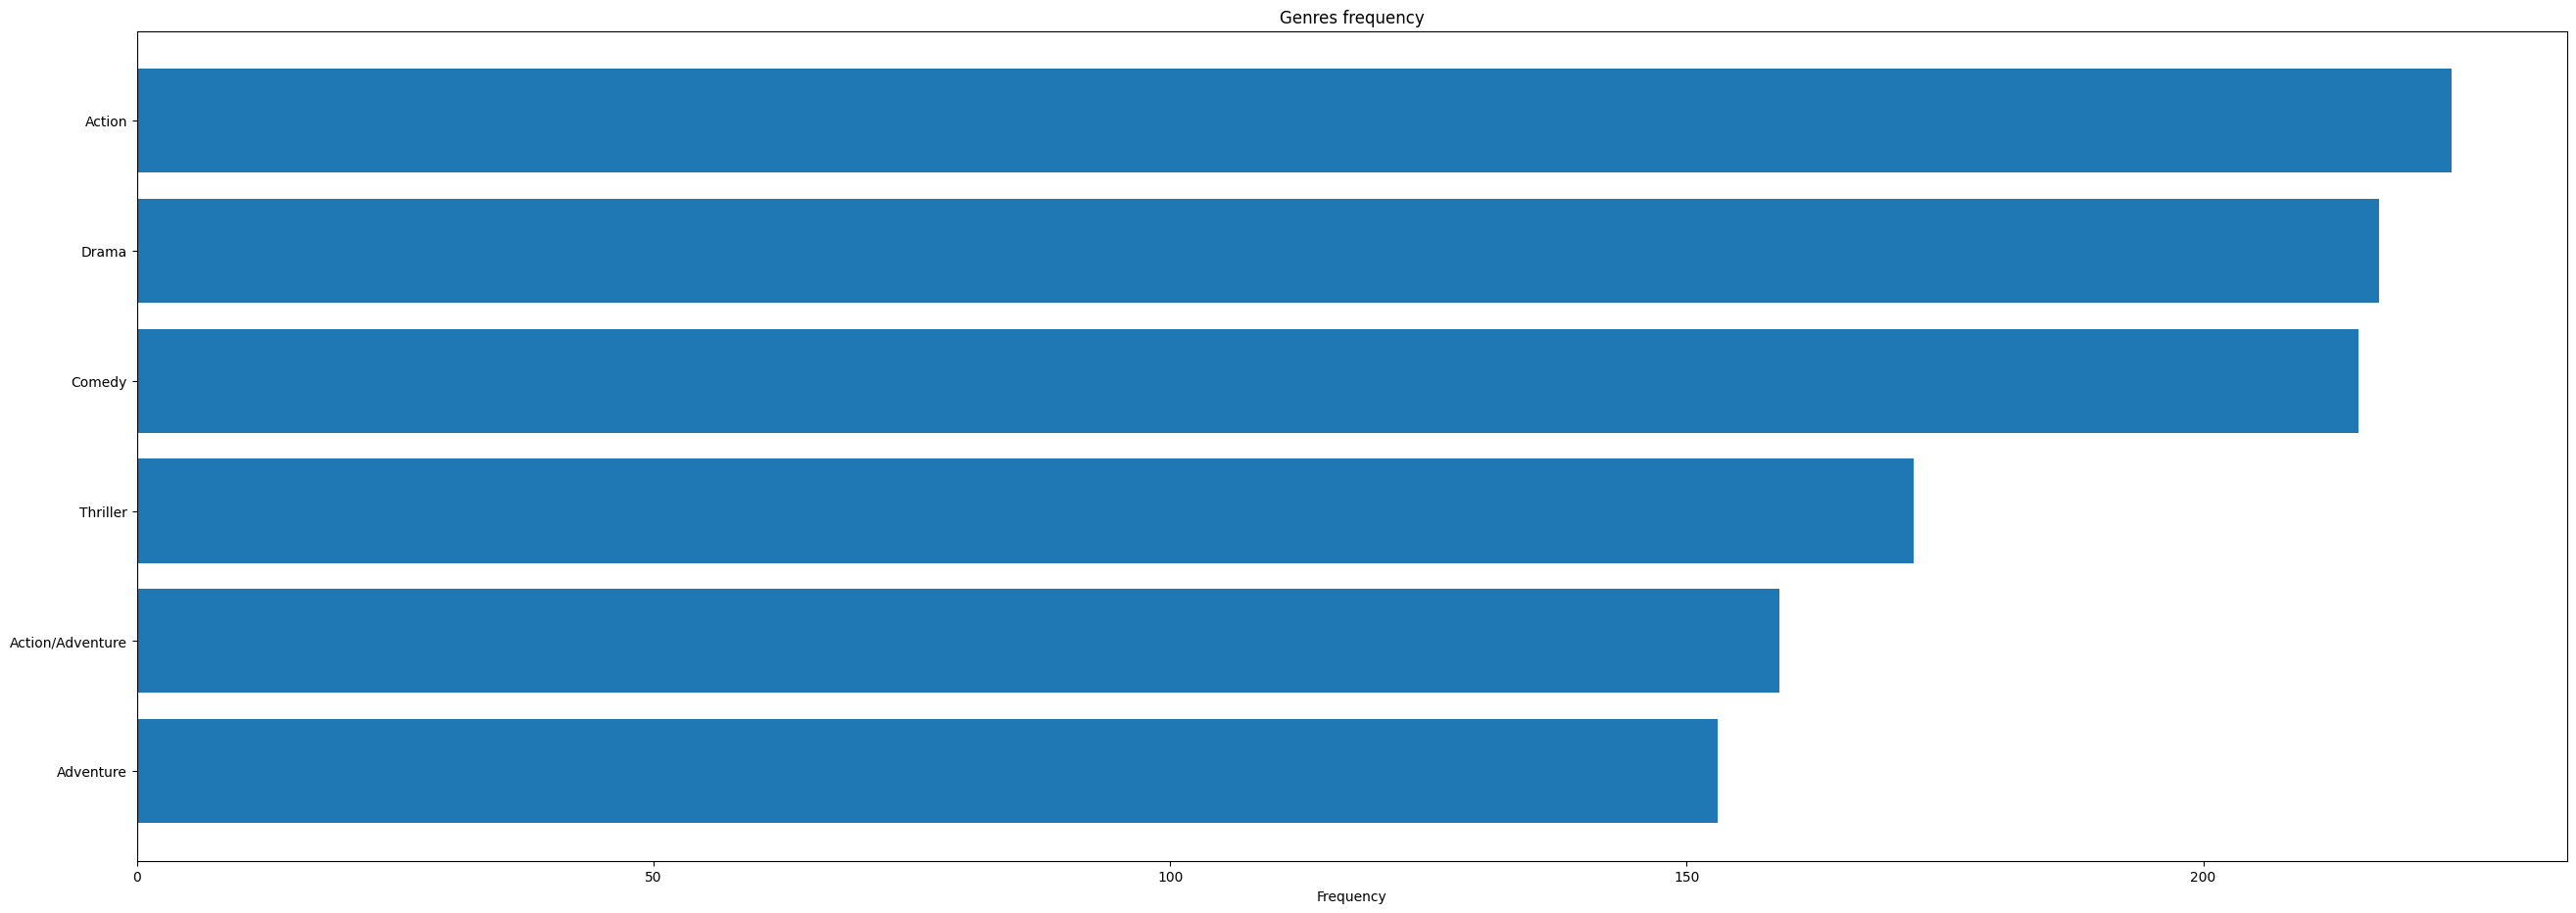

In [47]:
genres = character_meta_movie['movie_genres_ids'].apply(lambda x: list(x)).values
genres = flatten(genres)

unique, counts = np.unique(genres, return_counts=True)
genres_freq = (list(zip(unique, counts)))
sorted_genres = (sorted(genres_freq, key=lambda x: x[1], reverse=True))[:6]
genres, counts = zip(*sorted_genres[::-1])

fig, ax = plt.subplots(figsize = (32, 11))
y_pos = np.arange(len(genres))
ax.barh(y_pos, counts, align='center')
ax.set_yticks(y_pos, labels=genres)
ax.set_xlabel('Frequency')
ax.set_title('Genres frequency')

plt.show()

#### Keeping unique actors

In [48]:
character_unique_actor = character_meta_movie.drop_duplicates(['freebase_actor_id'])

In [49]:
len(character_unique_actor) == character_meta_movie['freebase_actor_id'].nunique()

True

In [50]:
#character_unique_actor.loc[:, 'freebase_movie_id'] = character_meta_merged.groupby('freebase_actor_id').apply(lambda x: list(x['freebase_movie_id']))
character_meta_movie = character_meta_movie.sort_values(by='freebase_actor_id')
character_unique_actor = character_unique_actor.sort_values(by='freebase_actor_id')

In [51]:
character_unique_actor.loc[:, 'freebase_movie_id'] = (character_meta_movie.groupby('freebase_actor_id').apply(lambda x: list(x['freebase_movie_id']))).values

In [52]:
character_unique_actor.loc[:, 'character_name'] = (character_meta_merged.groupby('freebase_actor_id').apply(lambda x: list(x['character_name']))).values

In [53]:
character_unique_actor.loc[:, 'character_type'] = (character_meta_movie.groupby('freebase_actor_id').apply(lambda x: list(x['character_type']))).values

In [54]:
character_unique_actor.loc[:, 'movie_genres'] = (character_meta_movie.groupby('freebase_actor_id').apply(lambda x: list(x['movie_genres_ids']))).values

In [55]:
character_unique_actor.loc[:, 'languages'] = (character_meta_movie.groupby('freebase_actor_id').apply(lambda x: list(x['movie_languages_ids']))).values

In [56]:
character_unique_actor.loc[:, 'countries'] = (character_meta_movie.groupby('freebase_actor_id').apply(lambda x: list(x['movie_countries_ids']))).values

In [57]:
# we take the average movie revenue 
# remove null values out of the computation
character_unique_actor.loc[:, 'average_movie_revenue'] = character_meta_movie.groupby('freebase_actor_id').apply(lambda x: np.mean(list(x['movie_box_office_revenue'][x['movie_box_office_revenue'].notnull() == True]))).values

C:\Users\naelo\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\naelo\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Next we keep the most frequent values in the merged dataframe that have list attributes

In [58]:
def most_frequent(arr):
    arr = list(arr[0])
    values, counts = np.unique(arr, return_counts=True)
    index = np.argmax(counts)
    return values[index]

def most_frequent_list(arr):
    values, counts = np.unique(arr, return_counts=True)
    index = np.argmax(counts)
    return values[index]

def keep_most_frequent(df, column_name):
    return df.groupby('freebase_actor_id').apply(lambda x: most_frequent(x[column_name].values))

In [59]:
character_unique_actor.loc[:, 'country'] = character_unique_actor['countries'].apply(lambda x: most_frequent(x))

In [60]:
character_unique_actor.loc[:, 'language'] = character_unique_actor['languages'].apply(lambda x: most_frequent(x))

In [61]:
character_unique_actor.loc[:, 'genre'] = character_unique_actor['movie_genres'].apply(lambda x: most_frequent(x))

In [62]:
character_unique_actor.loc[:, 'character'] = character_unique_actor['character_type'].apply(lambda x: most_frequent_list(x))

In [63]:
character_unique_actor['movie_number'] = character_unique_actor['freebase_movie_id'].apply(lambda x: len(x))

In [64]:
# filter nan values
character_unique_actor = character_unique_actor[character_unique_actor['average_movie_revenue'].notnull()]

In [65]:
character_unique_actor.index = character_unique_actor.actor_name
character_unique_actor.head()

,wikipedia_movie_id_x,freebase_movie_id,movie_release_date_x,character_name,actor_date_of_birth,actor_gender,actor_height_m,actor_ethnicity_id,actor_name,actor_age_at_movie_release,...,movie_genres_ids,movie_genres,languages,countries,average_movie_revenue,country,language,genre,character,movie_number
actor_name,,,,,,,,,,,,,,,,,,,,,
Kevin Costner,2087781,[/m/06l9q0],1985-07-10,[Jake],1955-01-18,M,1.850,/m/09vc4s,Kevin Costner,30.0,...,"(Ensemble Film, Action/Adventure, Revisionist Western, Western, Comedy, Action)","[(Ensemble Film, Action/Adventure, Revisionist Western, Western, Comedy, Action)]",[(English Language)],[(United States of America)],3.219257e+07,United States of America,English Language,Action,young_gun,1
Peter Stormare,142430,[/m/011yhm],1996-03-08,[Gaear Grimsrud],1953-08-27,M,1.892,/m/065b6q,Peter Stormare,42.0,...,"(Crime Fiction, Thriller, Indie, Drama, Comedy, Black comedy, Neo-noir)","[(Crime Fiction, Thriller, Indie, Drama, Comedy, Black comedy, Neo-noir)]",[(English Language)],"[(United States of America, United Kingdom)]",6.061198e+07,United Kingdom,English Language,Black comedy,psycho_for_hire,1
Simon Pegg,8172248,"[/m/02t_h3, /m/03c_4fq, /m/026rrf_]",2007-09-07,"[Dennis, Sidney Young, Shaun]",1970-02-14,M,1.780,NaN,Simon Pegg,37.0,...,"(Sports, Romantic comedy, Romance Film, Comedy, Slapstick)","[(Parody, Romantic comedy, Horror, Doomsday film, Cult, Comedy, Zombie Film, Black comedy, Horror Comedy), (Romantic comedy, Romance Film, Comedy), (Sports, Romantic comedy, Romance Film, Comedy, Slapstick)]","[(English Language), (English Language), (English Language)]","[(United Kingdom), (United Kingdom), (United Kingdom)]",2.755157e+07,United Kingdom,English Language,Black comedy,loser_protagonist,3
Richard Gere,5549932,[/m/0ds2hb],1990-01-12,[Dennis Peck],1949-08-31,M,1.800,/m/033tf_,Richard Gere,40.0,...,"(Thriller, Crime Fiction, Drama, Suspense, Crime Thriller)","[(Thriller, Crime Fiction, Drama, Suspense, Crime Thriller)]","[(English Language, Spanish Language)]",[(United States of America)],2.773439e+07,United States of America,English Language,Crime Fiction,dirty_cop,1
The Rock,284697,[/m/01pvs1],2003-09-22,[Beck],1972-05-02,M,1.960,/m/07j80c,The Rock,31.0,...,"(Thriller, Buddy film, Adventure, Jungle Film, Action Comedy, Action/Adventure, Adventure Comedy, Comedy, Action)","[(Thriller, Buddy film, Adventure, Jungle Film, Action Comedy, Action/Adventure, Adventure Comedy, Comedy, Action)]","[(Portuguese Language, English Language)]",[(United States of America)],8.091649e+07,United States of America,English Language,Action,bounty_hunter,1


In [66]:
character_unique_actor['success'] = character_unique_actor.apply(lambda x: x['average_movie_revenue'] * x['movie_number'], axis=1)

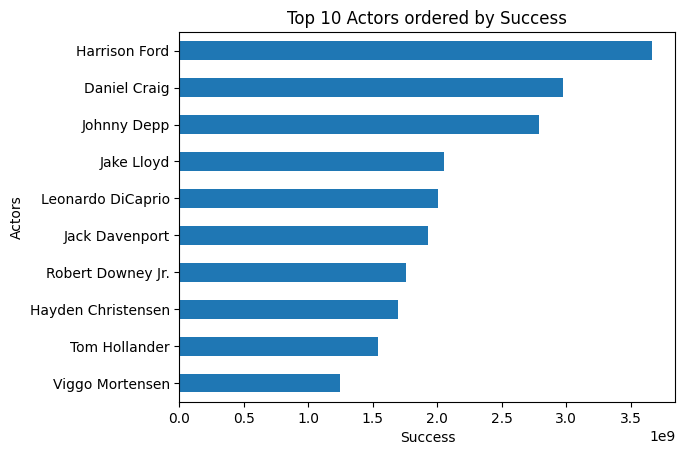

In [67]:
# Sort the dataframe by the 'success' attribute
character_unique_actor_sorted = character_unique_actor.sort_values(by='success', ascending=False).head(10)

# Reverse the order of the rows
character_unique_actor_sorted = character_unique_actor_sorted.iloc[::-1]

# Create a horizontal bar plot
character_unique_actor_sorted['success'].plot.barh()


# TODO: change the style of the bar plot
# Add labels and a title
plt.xlabel('Success')
plt.ylabel('Actors')
plt.title('Top 10 Actors ordered by Success')

# Show the plot
plt.show()

### Principal Components Analysis 

In [275]:
character_unique_pca = character_unique_actor[['success', 'genre', 'average_movie_revenue', 'character', 'actor_age_at_movie_release', 'actor_gender', 'movie_number']]

In [276]:
character_unique_pca = character_unique_pca[character_unique_pca.actor_age_at_movie_release.notnull()]

In [278]:
import pandas as pd

# Select the categorical columns
cat_columns = ['character', 'genre']
cont_columns = ['average_movie_revenue', 'actor_age_at_movie_release']

# standardization
character_unique_pca[cont_columns] = character_unique_pca[cont_columns] - np.mean(character_unique_pca[cont_columns])
character_unique_pca[cont_columns] = character_unique_pca[cont_columns] / np.std(character_unique_pca[cont_columns])

features = cat_columns + cont_columns

# One-hot encode the categorical columns
character_unique_pca = character_unique_pca.sort_values(by='success', ascending=False)
character_unique_actor_ohe = pd.get_dummies(character_unique_pca[features], columns=cat_columns)
character_unique_actor_ohe.head()

C:\Users\naelo\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,average_movie_revenue,actor_age_at_movie_release,character_absent_minded_professor,character_adventurer_archaeologist,character_arrogant_kungfu_guy,character_big_man_on_campus,character_bounty_hunter,character_brainless_beauty,character_broken_bird,character_bromantic_foil,...,genre_Costume drama,genre_Crime Drama,genre_Crime Fiction,genre_Crime Thriller,genre_Cult,genre_Docudrama,genre_Doomsday film,genre_Drama,genre_Haunted House Film,genre_Horror
actor_name,,,,,,,,,,,,,,,,,,,,,
Harrison Ford,1.714500,2.285337,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Daniel Craig,2.496517,0.257050,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Johnny Depp,1.091074,0.500445,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jake Lloyd,4.954326,-2.176894,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Leonardo DiCaprio,2.908064,-0.148607,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [279]:
character_unique_actor_ohe.isnull().sum().sum()

0

In [280]:
from sklearn.decomposition import PCA

# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to the data
pca.fit(character_unique_actor_ohe)

# Transform the data using the PCA model
character_unique_actor_pca = pca.transform(character_unique_actor_ohe)

# The transformed data is now stored in character_unique_actor_pca

Next we visualize the Principal Components Analysis on a 2D-Plane

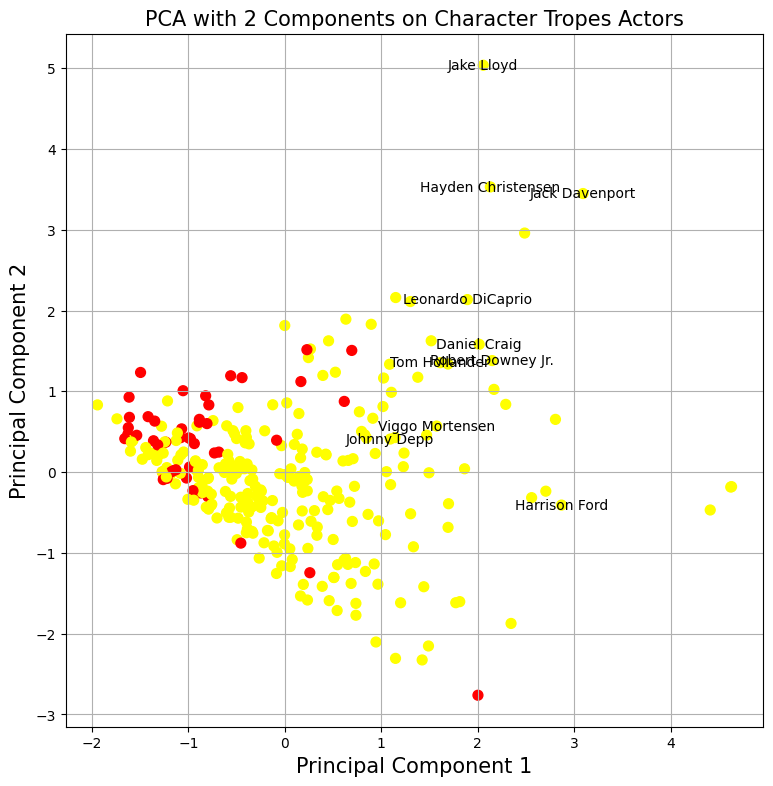

In [306]:
# Extract the first and second components of the PCA
x = character_unique_actor_pca[:, 0]
y = character_unique_actor_pca[:, 1]

# Create a scatter plot
plt.figure(figsize=(9,9))
plt.xlabel('Principal Component 1', fontsize = 15)  
plt.ylabel('Principal Component 2', fontsize = 15)  
plt.title("PCA with 2 Components on Character Tropes Actors", fontsize=15) 
plt.grid()

color = character_unique_pca['actor_gender'].apply(lambda x: 'yellow' if (x == 'M') else 'red')

character_unique_pca = character_unique_pca.sort_values(by='success', ascending=False)

# Add labels to the points
for i, index in enumerate(character_unique_pca.head(10).index):
    plt.text(x[i], y[i], index, ha='center', va='center', fontsize=10, animated=True)
    

plt.scatter(x, y, s=50, c = color)
plt.show()

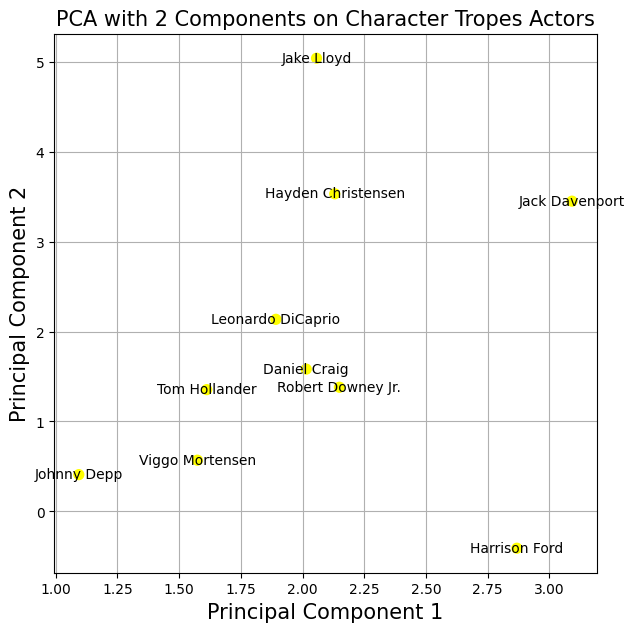

In [313]:
x_top = character_unique_actor_pca[:10, 0]
y_top = character_unique_actor_pca[:10, 1]

# Create a scatter plot
plt.figure(figsize=(7,7))
plt.xlabel('Principal Component 1', fontsize = 15)  
plt.ylabel('Principal Component 2', fontsize = 15)  
plt.title("PCA with 2 Components on Character Tropes Actors", fontsize=15) 
plt.grid()
plt.scatter(x_top, y_top, s=50, c = color[:10])

# Add labels to the points
for i, index in enumerate(character_unique_pca.head(10).index):
    plt.text(x[i], y[i], index, ha='center', va='center', fontsize=10, animated=True)
    
plt.show()

### Co-Stardom Graph

In [242]:
import pyvis

In [268]:
G = nx.karate_club_graph()

In [271]:
# Create the Pyvis visualization
vis = pyvis.network.Network(height="750px", width="100%", bgcolor="#D3D3D3", font_color="white", select_menu="True")

In [272]:
# Add nodes and edges to the visualization
for node in G.nodes:
    vis.add_node(node, label=node)
for edge in G.edges:
    vis.add_edge(edge[0], edge[1])

# Set the layout and show the visualization
vis.set_options("""
    var options = {
        "physics": {
            "barnesHut": {
                "gravitationalConstant": -35000
            }
        }
    }
""")
vis.show("karate_club_graph.html")

### Opposites attract or Like attracts like ?

Next we want to compare the proximity of Actors in the PCA analysis (using Euclidean distance) and shortest path on the Co-Stardom graph.

In [273]:
def filter_character_actor(array):
    filter_actor = [actor for actor in array if actor in character_unique_actor.freebase_actor_id.values]
    return filter_actor

In [274]:
character_unique_actor.loc[list(character_unique_actor.index)[0]]

wikipedia_movie_id_x             2087781
freebase_movie_id            [/m/06l9q0]
movie_release_date_x          1985-07-10
character_name                    [Jake]
actor_date_of_birth           1955-01-18
                              ...       
language                English Language
genre                             Action
character                      young_gun
movie_number                           1
success                       32192570.0
Name: Kevin Costner, Length: 33, dtype: object

In [266]:
movie_to_actors = character_meta[['freebase_actor_id','freebase_movie_id']].groupby('freebase_movie_id').apply(lambda x: list(x['freebase_actor_id'].values))

In [ ]:
def filter_actor_name(array):
    print(array)
    character_meta[character_meta['freebase_actor_id']]

In [267]:
print(movie_to_actors)

freebase_movie_id
/m/011_mj                                                                                                                                   [nan, /m/01lc5, /m/03d36rf, /m/0gclz8m, /m/043j_fq, /m/08lk66, /m/03cn95y, /m/0ksm_r, /m/07mmg5]
/m/011_p6                                                                                                                                                                             [/m/02ysx, /m/0ksbyz, /m/05bwd6, /m/03jl2r, /m/06mwbj]
/m/011_zy                                                                                                                                                                                      [/m/039mzr, /m/06bxsw, /m/04jxzf, /m/0266kbw]
/m/011wtv                          [/m/07r1h, /m/0k525, /m/02k_c1, /m/03w4sh, /m/04ljfv5, /m/0306j0, /m/08v5rq, /m/01wxyx1, /m/02d42t, /m/03grhv8, /m/0jdhp, /m/026_w57, /m/012q4n, /m/02yx4j, /m/0g9qh0h, /m/0fg8vz, /m/04xsr4, /m/0261hjx]
/m/011x_4    [/m/0ktdv3, /m/0283dk

In [238]:
# Use the `apply` method and a lambda function to filter the Series
movie_to_actors = movie_to_actors.apply(lambda x: x[0] if (len(x > 0)) else None)
movie_to_actors = movie_to_actors.dropna()

In [240]:
movie_to_actors = movie_to_actors.apply(lambda x: list(map(lambda a: character_meta[character_meta.freebase_actor_id == a].actor_name, x)))

KeyboardInterrupt: 

In [238]:
# Use the `apply` method and a lambda function to filter the Series
movie_to_actors = movie_to_actors.apply(lambda x: x[0] if (len(x > 0)) else None)
movie_to_actors = movie_to_actors.dropna()

In [213]:
movie_to_actors = dict(movie_to_actors)

In [216]:
movie_to_actors

{'/m/011wtv': ['Tom Cruise', 'Samantha Morton', 'Peter Stormare'],
 '/m/011x_4': ['Bill Murray'],
 '/m/011xg5': ['Jude Law', 'Robin Williams', 'Ben Kingsley'],
 '/m/011xrr': ['John Lithgow',
  'Jamie Lee Curtis',
  'Peter Weller',
  'Clancy Brown',
  'Ronald Lacey',
  'John Lithgow',
  'Christopher Lloyd'],
 '/m/011ycb': ['Mira Sorvino', 'Ralph Fiennes'],
 '/m/011yd2': ['Bill Paxton', 'Tom Hanks'],
 '/m/011ydl': ['Hugo Weaving'],
 '/m/011yhm': ['William H. Macy', 'Peter Stormare'],
 '/m/011ykb': ['Tom Cruise'],
 '/m/011yl_': ['Nicholas Bell'],
 '/m/011yn5': ['Greg Kinnear', 'Jack Nicholson'],
 '/m/011ypx': ['Robin Williams', 'Matt Damon'],
 '/m/011yqc': ['Russell Crowe', 'Guy Pearce'],
 '/m/011yr9': ['Christopher Eccleston', 'Joseph Fiennes', 'Daniel Craig'],
 '/m/011ysn': ['Sean Penn',
  'Elias Koteas',
  'John Cusack',
  'Woody Harrelson',
  'John Travolta'],
 '/m/011yth': ['Al Pacino', 'Russell Crowe', 'Christopher Plummer'],
 '/m/011ywj': ['Clive Owen', 'Tom Hollander'],
 '/m/011yx

In [217]:
actor_to_movies = character_unique_actor['freebase_movie_id']

In [218]:
mask = actor_to_movies.index.map(lambda x: x in character_unique_actor.index)
actor_to_movies

actor_name
Kevin Costner                                    [/m/06l9q0]
Peter Stormare                                   [/m/011yhm]
Simon Pegg               [/m/02t_h3, /m/03c_4fq, /m/026rrf_]
Richard Gere                                     [/m/0ds2hb]
The Rock                                         [/m/01pvs1]
                                        ...                 
Christine Taylor                                 [/m/06r5q1]
Sean Astin                                       [/m/01q48n]
Sean Penn                             [/m/02bc6c, /m/02bc6c]
Arnold Schwarzenegger                            [/m/03_8cd]
Anthony Hopkins                         [/m/07cyl, /m/07cyl]
Name: freebase_movie_id, Length: 316, dtype: object

In [219]:
G = nx.graph.Graph()

In [220]:
# We make the first actor-to-actor graph.
# We construct the graph with actor nodes
for key in actor_to_movies.keys():
    G.add_node(key)

In [224]:
# For each actor, we get the movies he played in
for key in actor_to_movies.keys():
    set_of_movies = set(actor_to_movies[key])
    list_of_actors = []
    # For each movies, we get the list of actors that played in them
    for movie in set_of_movies:
        actors_for_one_movie = set(movie_to_actors[movie])
        actors_cocast = (character_unique_actor.loc[character_unique_actor['freebase_actor_id'].isin(movie_to_actors[movie])].freebase_actor_id.values)
        list_of_actors += filter_character_actor(actors_cocast)
    # We get a final list of all the actors an actor has co-starred with 
    # and remove the original actor so that we have no self-edge
    final_list_of_actors = set(list_of_actors) - set(key)
    # We transform the list of actors into a list of tuples of the shape (actor, actor) ( which will be the edges the networkx graph will add )
    final_list_of_actors = map(lambda x: (key, x), final_list_of_actors)
    # We add thes edges ( connections ) to the graph
    G.add_edges_from(final_list_of_actors)

In [225]:
G.size()

0

In [226]:
# We remove self-loop edges
G.remove_edges_from(nx.selfloop_edges(G))
G.size()

0

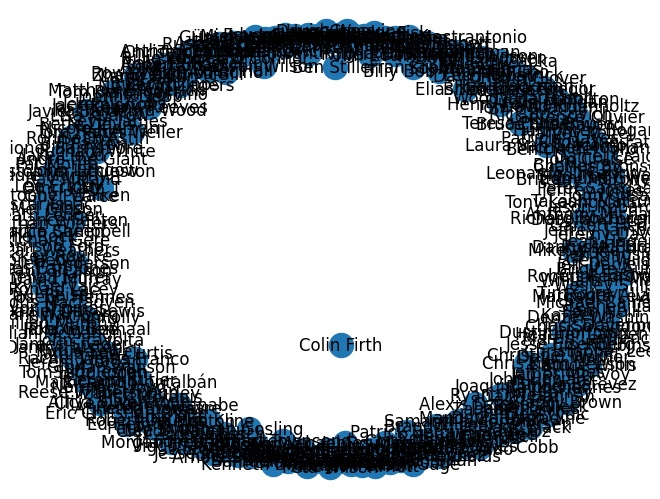

CPU times: total: 1.28 s
Wall time: 1.3 s


In [227]:
%%time
nx.draw(G, with_labels=True)
plt.show()

Text(0.5, 1.0, "Distribution of node's degrees")

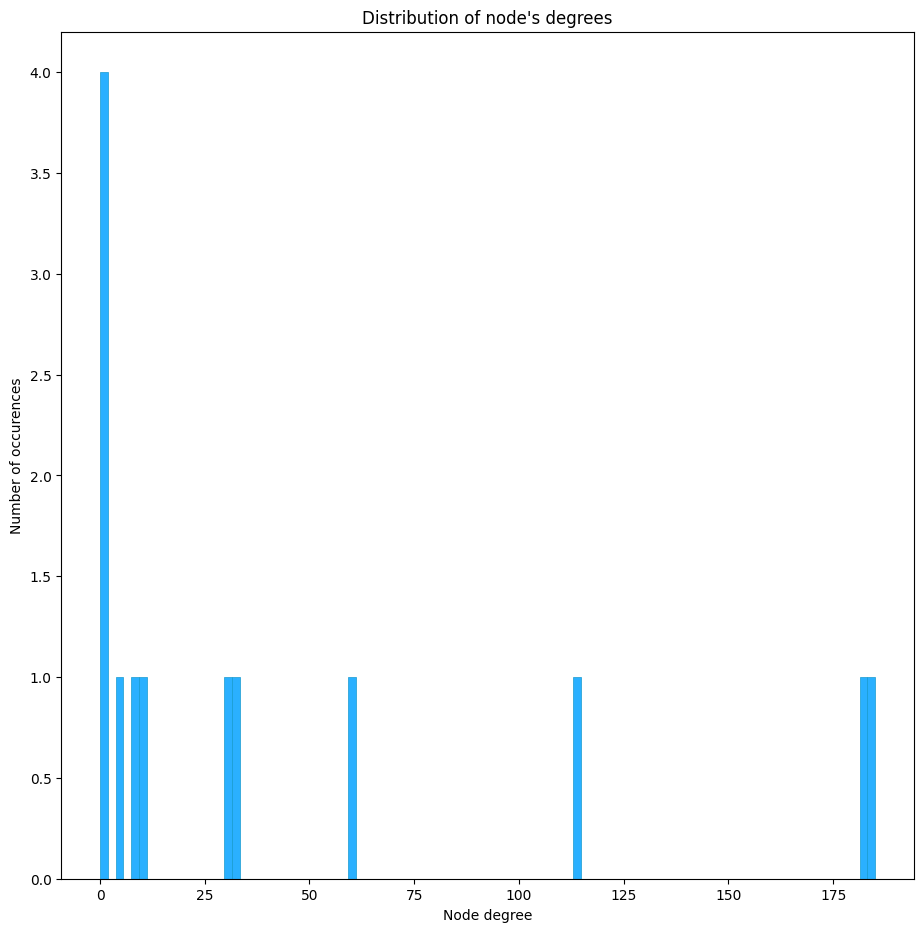

In [104]:
# We plot the distribution of the node's degrees.
plt.figure(figsize=(11,11))
plt.hist(nx.degree_histogram(G), log=False, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Node degree")
plt.ylabel("Number of occurences")
plt.title("Distribution of node's degrees")

## IMDb Datasets Exploratory Data Analysis

### Loading the datasets

In [32]:
DATA_FOLDER = 'data/imdb/'

TITLES_AKA = DATA_FOLDER+'title.akas.tsv.gz'
TITLES_BASICS = DATA_FOLDER+'title.basics.tsv.gz'
TITLES_CREW = DATA_FOLDER+'title.crew.tsv.gz'
TITLES_PRINCIPLES = DATA_FOLDER+'title.principals.tsv.gz'
NAME_BASICS = DATA_FOLDER+'name.basics.tsv.gz'
WRITERS = DATA_FOLDER+"writers_after2012.pkl.gz"
DIRECTORS = DATA_FOLDER+"directors_after2012.pkl.gz"

In [33]:
# load dataset
titles_meta = pd.read_csv(TITLES_AKA, sep='\t')
titles_basics = pd.read_csv(TITLES_BASICS, sep='\t')
titles_crew = pd.read_csv(TITLES_CREW, sep='\t')
titles_principles = pd.read_csv(TITLES_PRINCIPLES, sep='\t')
name_basics = pd.read_csv(NAME_BASICS, sep='\t')

/var/folders/87/tn6r54lj43nfjcwgfnk48zs40000gn/T/ipykernel_21820/74639776.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  titles_meta = pd.read_csv(TITLES_AKA, sep='\t')
/var/folders/87/tn6r54lj43nfjcwgfnk48zs40000gn/T/ipykernel_21820/74639776.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles_basics = pd.read_csv(TITLES_BASICS, sep='\t')


In [34]:
titles_meta.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [35]:
titles_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [36]:
titles_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [37]:
titles_principles.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [38]:
name_basics.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0050419,tt0053137,tt0072308,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0071877,tt0038355,tt0037382"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0056404,tt0054452,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0078723,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0083922"


### Filtering and pre-processing the data

#### Films

In [39]:
# During this EDA, we focus on movies after 2012, as we already have movies before 2012
threshold_year = 2012

# From the titles_aka, we only retain the titleId and region, for the original titles
df_titles_aka = titles_meta[['titleId', 'ordering', 'title']][(titles_meta['isOriginalTitle']==1)]

# We retained only non-adult movies
df_basics = titles_basics[(titles_basics['titleType'] == 'movie') & (titles_basics['isAdult'] == 0)]
df_basics = df_basics.drop(['titleType', 'isAdult', 'endYear'], axis=1)
df_basics = df_basics[df_basics['startYear'] != r"\N"]
df_basics['startYear'] = df_basics['startYear'].astype(int)

after_treshold = list(df_basics['tconst'][df_basics['startYear'] >= threshold_year])

In [40]:
df_titles_aka.head()

,titleId,ordering,title
6,tt0000001,7,Carmencita
8,tt0000002,1,Le clown et ses chiens
21,tt0000003,6,Pauvre Pierrot
25,tt0000004,1,Un bon bock
34,tt0000005,11,Blacksmith Scene


#### Writers and directors

In [41]:
df_writers_per_movie = titles_crew[['tconst', 'writers']]
df_directors_per_movie = titles_crew[['tconst', 'directors']]

In [42]:
# we selected only movies after the 2012, as we already have movies before 2012.
# and took only movies with writers/directors
df_writers_per_movie = df_writers_per_movie[(df_writers_per_movie['tconst'].isin(after_treshold)) &
                                           (df_writers_per_movie['writers'] != r"\N")]
df_directors_per_movie = df_directors_per_movie[(df_directors_per_movie['tconst'].isin(after_treshold)) &
                                               (df_directors_per_movie['directors'] != r"\N")]

In [43]:
# Going from movie's id with their writers/directors, to writers/directors with the movies they wrote/directed

df_writers_per_movie = df_writers_per_movie.assign(writers=df_writers_per_movie.writers.str.split(","))
df_writers_per_movie = df_writers_per_movie.writers.apply(pd.Series) \
    .merge(df_writers_per_movie, right_index=True, left_index=True) \
    .drop(["writers"], axis=1) \
    .melt(id_vars=['tconst'], value_name="writers") \
    .drop("variable", axis=1) \
    .dropna()
df_writers_per_movie = df_writers_per_movie.groupby('writers')['tconst'].apply(list).to_frame()

df_directors_per_movie = df_directors_per_movie.assign(directors=df_directors_per_movie.directors.str.split(","))
df_directors_per_movie = df_directors_per_movie.directors.apply(pd.Series) \
    .merge(df_directors_per_movie, right_index=True, left_index=True) \
    .drop(["directors"], axis=1) \
    .melt(id_vars=['tconst'], value_name="directors") \
    .drop("variable", axis=1) \
    .dropna()
df_directors_per_movie = df_directors_per_movie.groupby('directors')['tconst'].apply(list).to_frame()

In [44]:
df_writers_per_movie.head()

,tconst
writers,
nm0000041,"[tt2404435, tt9051908]"
nm0000054,[tt2077747]
nm0000080,[tt0069049]
nm0000083,"[tt11192552, tt19064180]"
nm0000092,"[tt3872778, tt0481499]"


In [45]:
df_directors_per_movie.head()

,tconst
directors,
nm0000080,"[tt0069049, tt12789550]"
nm0000095,"[tt1859650, tt2334873, tt2870756, tt3715320, tt4513674, tt5825380, tt7139936, tt8593904]"
nm0000108,"[tt17009348, tt20218618, tt2239822, tt2404311, tt2872732, tt7456310]"
nm0000110,"[tt1205537, tt12789558, tt1661199, tt22687790, tt3089630, tt3402236, tt7657566, tt9206798, tt5226844, tt5943392]"
nm0000114,[tt15669314]


In [46]:
#Pickling the final dataframes
df_writers_per_movie.to_pickle(WRITERS)
df_directors_per_movie.to_pickle(DIRECTORS)  

In [47]:
df_writers = pd.read_pickle(WRITERS) 
df_directors = pd.read_pickle(DIRECTORS) 

#### Actors

In [48]:
# Actors with the list of movies they played in
# Issue with this because some actors are also directors or writers, and in that case
# we will not count all the movies they were in
df_actors = titles_principles[['tconst', 'nconst']][((titles_principles['category']=='actor') | 
                                                    (titles_principles['category']=='actress')) &
                                                   (titles_principles['tconst'].isin(after_treshold))]

df_actors = df_actors.assign(nconst=df_actors.nconst.str.split(","))
df_actors = df_actors.nconst.apply(pd.Series) \
    .merge(df_actors, right_index=True, left_index=True) \
    .drop(["nconst"], axis=1) \
    .melt(id_vars=['tconst'], value_name="nconst") \
    .drop("variable", axis=1) \
    .dropna()
df_actors = df_actors.groupby('nconst')['tconst'].apply(list).to_frame()

In [49]:
df_actors.head()

,tconst
nconst,
nm0000047,[tt10627584]
nm0000084,"[tt10670442, tt3125472, tt4566758, tt4591310, tt8499638]"
nm0000087,"[tt16986382, tt7529350]"
nm0000090,[tt3493020]
nm0000092,"[tt10083612, tt13103340, tt14549270, tt1979172, tt2262270, tt2397461, tt3872778, tt4177856, tt4426464, tt5277030, tt8619854]"


#### Crew information

In [50]:
name_basics.index = name_basics['nconst']
df_name = name_basics.drop(['nconst', 'knownForTitles'], axis=1)

In [68]:
# Merging ids with actual crew information

df_actors_info = df_actors.merge(df_name, how='inner', right_index=True, left_index=True)
df_writers_info = df_writers.merge(df_name, how='inner', right_index=True, left_index=True)
df_directors_info = df_directors.merge(df_name, how='inner', right_index=True, left_index=True)

df_actors_info.head()

,tconst,nb of movies,primaryName,birthYear,deathYear,primaryProfession
nconst,,,,,,
nm0000047,[tt10627584],1,Sophia Loren,1934,\N,"actress,soundtrack"
nm0000084,"[tt10670442, tt3125472, tt4566758, tt4591310, tt8499638]",5,Gong Li,1965,\N,"actress,producer"
nm0000087,"[tt16986382, tt7529350]",2,Elena Koreneva,1953,\N,"actress,casting_director,soundtrack"
nm0000090,[tt3493020],1,Armin Mueller-Stahl,1930,\N,"actor,director,writer"
nm0000092,"[tt10083612, tt13103340, tt14549270, tt1979172, tt2262270, tt2397461, tt3872778, tt4177856, tt4426464, tt5277030, tt8619854]",11,John Cleese,1939,\N,"actor,writer,producer"


In [69]:
# Removing crew with no birthyear

df_actors_info = df_actors_info[df_actors_info['birthYear'] == r"\N"]
df_writers_info = df_writers_info[df_writers_info['birthYear'] == r"\N"]
df_directors_info = df_directors_info[df_directors_info['birthYear'] == r"\N"]

In [70]:
# Creating crew from name_basics (all the crew merged)
# Known for section doesn't contain all the movies

df_crew = name_basics[(name_basics['birthYear'] != r"\N") & (name_basics['knownForTitles'] != r"\N")]

### Crew initial analysis

In [71]:
df_crew.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,,
nm0000001,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0050419,tt0053137,tt0072308,tt0031983"
nm0000002,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0071877,tt0038355,tt0037382"
nm0000003,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0056404,tt0054452,tt0057345"
nm0000004,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0078723,tt0080455,tt0072562"
nm0000005,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0083922"


/var/folders/87/tn6r54lj43nfjcwgfnk48zs40000gn/T/ipykernel_21820/3230206763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crew['birthYear'] = df_crew['birthYear'].astype(int)


Text(0.5, 1.0, 'Distribution of the year of birth for the crew, histogram')

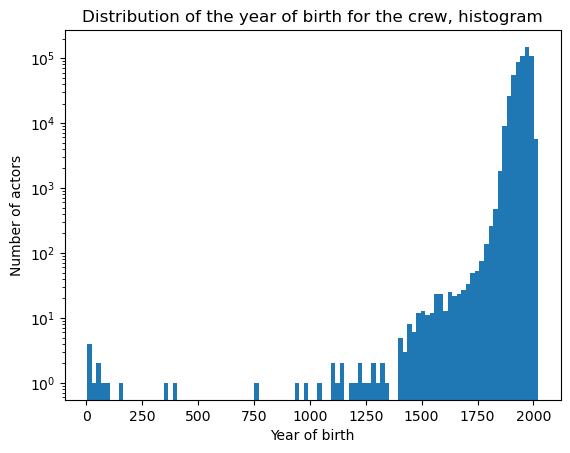

In [72]:
# Crew date of birth distribution

df_crew['birthYear'] = df_crew['birthYear'].astype(int)
plt.hist(df_crew['birthYear'].values, 
         bins = 100, log=True)

plt.xlabel('Year of birth')
plt.ylabel('Number of actors')
plt.title('Distribution of the year of birth for the crew, histogram')

In [73]:
# Top10 actors that played in the most nb of movies

df_actors['nb of movies'] = df_actors['tconst'].apply(lambda x : len(x)) 
df_top_actors = df_actors.sort_values(by='nb of movies', ascending=False).head(10)
df_top_actors = df_top_actors.merge(df_name, how='inner', right_index=True, left_on='nconst')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

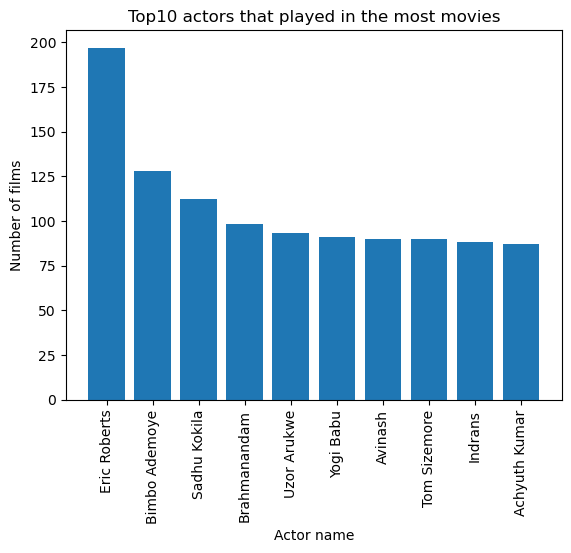

In [74]:
plt.bar(df_top_actors['primaryName'].values, df_top_actors['nb of movies'].values)

plt.xlabel('Actor name')
plt.ylabel('Number of films')
plt.title('Top10 actors that played in the most movies')
plt.xticks(rotation=90)

In [75]:
# Top10 directors that directed in the most nb of movies

df_directors['nb of movies'] = df_directors['tconst'].apply(lambda x : len(x)) 
df_top_directors = df_directors.sort_values(by='nb of movies', ascending=False).head(10)
df_top_directors = df_top_directors.merge(df_name, how='inner', right_index=True, left_index=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

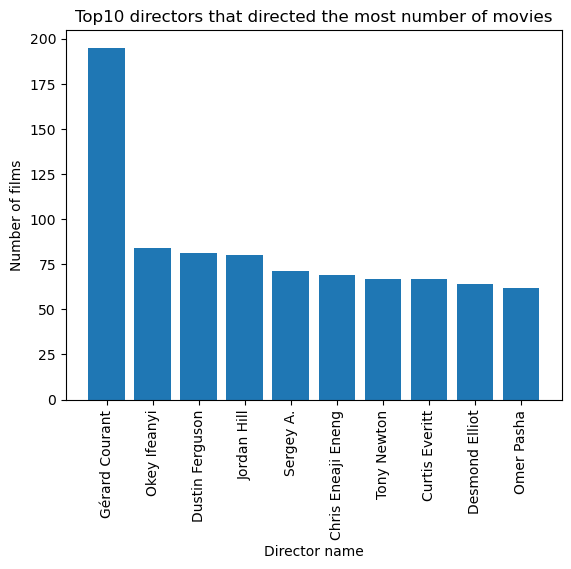

In [76]:
plt.bar(df_top_directors['primaryName'].values, df_top_directors['nb of movies'].values)

plt.xlabel('Director name')
plt.ylabel('Number of films')
plt.title('Top10 directors that directed the most number of movies')
plt.xticks(rotation=90)

In [77]:
# Top10 writers that directed in the most nb of movies

df_writers['nb of movies'] = df_writers['tconst'].apply(lambda x : len(x)) 
df_top_writers = df_writers.sort_values(by='nb of movies', ascending=False).head(10)
df_top_writers = df_top_writers.merge(df_name, how='inner', right_index=True, left_index=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

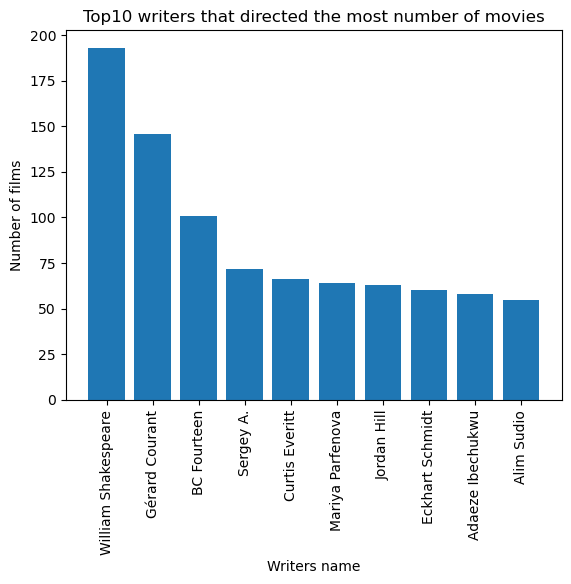

In [78]:
plt.bar(df_top_writers['primaryName'].values, df_top_writers['nb of movies'].values)

plt.xlabel('Writers name')
plt.ylabel('Number of films')
plt.title('Top10 writers that directed the most number of movies')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Distribution of number of movies actors played in')

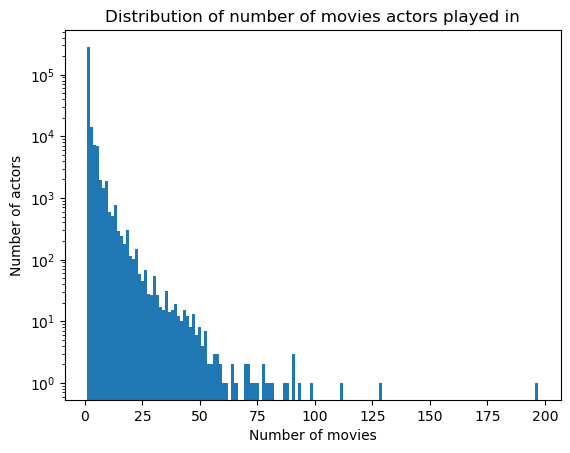

In [79]:
# Distribution of number of films in which actors played

plt.hist(df_actors['nb of movies'].values, 
         bins = 150, log=True)

plt.xlabel('Number of movies')
plt.ylabel('Number of actors')
plt.title('Distribution of number of movies actors played in')

Text(0.5, 1.0, 'Distribution of number of movies directors directed')

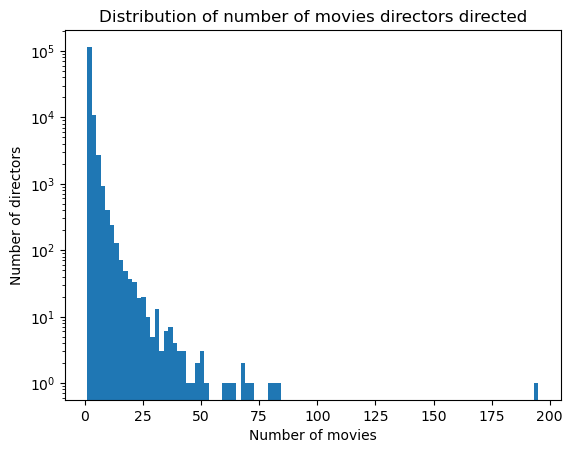

In [80]:
# Distribution of number of movies directed for directors

plt.hist(df_directors['nb of movies'].values, 
         bins = 100, log=True)

plt.xlabel('Number of movies')
plt.ylabel('Number of directors')
plt.title('Distribution of number of movies directors directed')

Text(0.5, 1.0, 'Distribution of number of movies writers wrote')

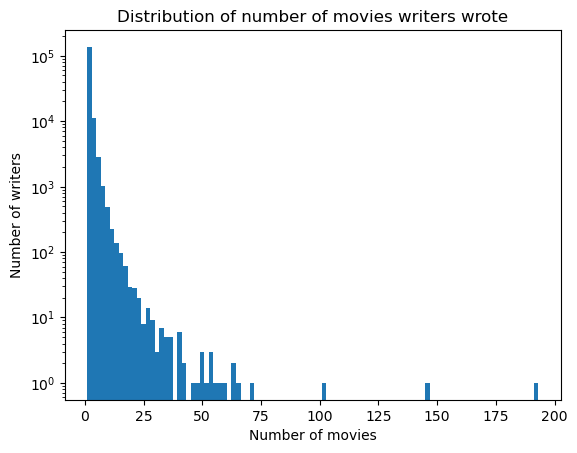

In [81]:
# Distribution of number of movies wrote for writers
plt.hist(df_writers['nb of movies'].values, 
         bins = 100, log=True)

plt.xlabel('Number of movies')
plt.ylabel('Number of writers')
plt.title('Distribution of number of movies writers wrote')

### Movies initial analysis

In [82]:
df_basics.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,1894,45,Romance
498,tt0000502,Bohemios,Bohemios,1905,100,\N
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama
610,tt0000615,Robbery Under Arms,Robbery Under Arms,1907,\N,Drama


In [ ]:
# Top10 most present movie genre

df_gp_genres['nb of films'] = df_basics[df_basics['genres'] != r"\N"].groupby('genres')['genres'].count().to_frame()
df_gp_genres = df_gp_genres.sort_values('nb of films',ascending=False).head(10)

In [ ]:
df_gp_genres

In [ ]:
plt.bar(list(df_gp_genres['genres'].index), df_gp_genres['genres'].values)

plt.xlabel('Genres')
plt.ylabel('Number of films')
plt.title('Top 10 most present film genres')
plt.xticks(rotation=90)

In [85]:
df_titles_aka.head()

,titleId,ordering,title
6,tt0000001,7,Carmencita
8,tt0000002,1,Le clown et ses chiens
21,tt0000003,6,Pauvre Pierrot
25,tt0000004,1,Un bon bock
34,tt0000005,11,Blacksmith Scene


In [ ]:
# Number of American movies vs the rest
# Titles aka contains original titles so, we can juste check the region to have the movie origin
df_movie_origin['nb of films'] = df_titles_aka[df_titles_aka['language'] != r"\N"].groupby('language')['language'].count().to_frame()
df_movie_origin

In [112]:
# Average runtime

df_runtimes = titles_basics[(titles_basics['titleType'] == 'movie') & (titles_basics['runtimeMinutes'] != r"\N")]
df_runtimes['runtimeMinutes'] = df_runtimes['runtimeMinutes'].astype(int)

/var/folders/87/tn6r54lj43nfjcwgfnk48zs40000gn/T/ipykernel_21820/1911121060.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runtimes['runtimeMinutes'] = df_runtimes['runtimeMinutes'].astype(int)


In [113]:
len(df_runtimes[df_runtimes['runtimeMinutes'] > 600])

92

In [114]:
df_runtimes = df_runtimes[df_runtimes['runtimeMinutes'] < 600]

Text(0.5, 1.0, 'Distribution of movie runtime')

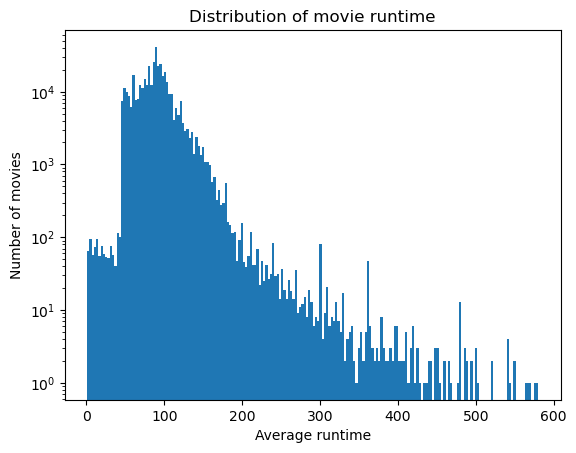

In [115]:
# Distribution of number of movies directed for directors

plt.hist(df_runtimes['runtimeMinutes'].values, 
         bins = 200, log=True)

plt.xlabel('Average runtime')
plt.ylabel('Number of movies')
plt.title('Distribution of movie runtime')

In [116]:
# Movie distribution per year
df_movie_years = titles_basics[(titles_basics['startYear'] != '\\N') &  (titles_basics['startYear'] != r"\N")
                               & (titles_basics['titleType'] == 'movie')]
df_movie_years['startYear'] = df_movie_years['startYear'].astype(int)

/var/folders/87/tn6r54lj43nfjcwgfnk48zs40000gn/T/ipykernel_21820/2394622519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_years['startYear'] = df_movie_years['startYear'].astype(int)


Text(0.5, 1.0, 'Distribution of movie releases per year')

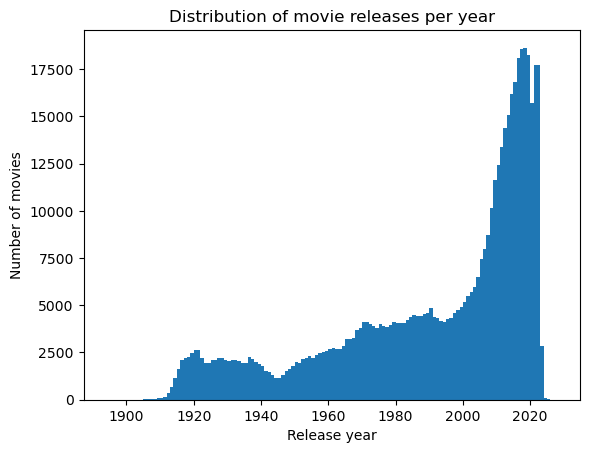

In [117]:
# Distribution of number of movies directed for directors

plt.hist(df_movie_years['startYear'].values, 
         bins = (df_movie_years['startYear'].max() - df_movie_years['startYear'].min()))

plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Distribution of movie releases per year')

## Data preprocessing

### Outlier and missing value correction using IMDb datset values

##### A. Missing values in movie_metadata

In [87]:
# Recap of missing values
# display null values for every column
(movie_meta.isna().sum()/len(movie_meta))*100

wikipedia_movie_id           0.000000
freebase_movie_id            0.000000
movie_name                   0.000000
movie_release_date           8.443743
movie_box_office_revenue    89.722416
movie_runtime               25.018045
movie_languages              0.000000
movie_countries              0.000000
movie_genres                 0.000000
movie_release_year           8.443743
movie_languages_ids          0.000000
movie_countries_ids          0.000000
movie_genres_ids             0.000000
dtype: float64

In [88]:
# merge title_akas and title_basics
len(titles_meta), len(titles_basics)

(33840590, 9374820)

In [89]:
titles_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [90]:
titles_data = titles_basics[['tconst', 'originalTitle', 'startYear', 'runtimeMinutes', 'titleType']]

In [91]:
titles_data.head()

,tconst,originalTitle,startYear,runtimeMinutes,titleType
0,tt0000001,Carmencita,1894,1,short
1,tt0000002,Le clown et ses chiens,1892,5,short
2,tt0000003,Pauvre Pierrot,1892,4,short
3,tt0000004,Un bon bock,1892,12,short
4,tt0000005,Blacksmith Scene,1893,1,short


In [92]:
len(titles_data)

9374820

In [93]:
# display null values in IMDb titles basics Dataset
titles_data.isna().sum()

tconst             0
originalTitle     11
startYear          0
runtimeMinutes     0
titleType          0
dtype: int64

In [94]:
titles_data.head()

,tconst,originalTitle,startYear,runtimeMinutes,titleType
0,tt0000001,Carmencita,1894,1,short
1,tt0000002,Le clown et ses chiens,1892,5,short
2,tt0000003,Pauvre Pierrot,1892,4,short
3,tt0000004,Un bon bock,1892,12,short
4,tt0000005,Blacksmith Scene,1893,1,short


In [95]:
# We only keep movies
movies_basics = titles_data[titles_data['titleType'] == 'movie']

In [96]:
# There are no missing values for movies
movies_basics.isna().sum()

tconst            0
originalTitle     0
startYear         0
runtimeMinutes    0
titleType         0
dtype: int64

In [97]:
movies_basics.loc[:, 'startYear'] = pd.to_numeric(movies_basics['startYear'], errors='coerce').astype(float)

/var/folders/87/tn6r54lj43nfjcwgfnk48zs40000gn/T/ipykernel_21820/1726473084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_basics.loc[:, 'startYear'] = pd.to_numeric(movies_basics['startYear'], errors='coerce').astype(float)


In [98]:
# merge imdb columns into the CMU dataset
movie_meta_imdb_merged = movie_meta.merge(movies_basics, how='left', left_on=['movie_name', 'movie_release_year'], right_on=['originalTitle', 'startYear'])

In [99]:
# Replace missing revenue values
movie_meta_imdb_merged['runtimeMinutes_2'] = pd.to_numeric(movie_meta_imdb_merged['runtimeMinutes'], errors='coerce').astype(float)
movie_meta_imdb_merged['movie_runtime_2'] = movie_meta_imdb_merged['movie_runtime']

movie_meta_imdb_merged.loc[~(movie_meta_imdb_merged['runtimeMinutes_2'].isnull()) & ((movie_meta_imdb_merged['movie_runtime_2'].isnull()) | (movie_meta_imdb_merged['runtimeMinutes_2'] != movie_meta_imdb_merged['movie_runtime_2'])), 'movie_runtime_2'] = movie_meta_imdb_merged['runtimeMinutes_2']

In [100]:
# Number of successfully replaced movie runtimes
len(movie_meta_imdb_merged[~(movie_meta_imdb_merged['runtimeMinutes_2'].isnull()) & ((movie_meta_imdb_merged['movie_runtime'].isnull()) | (movie_meta_imdb_merged['runtimeMinutes_2'] != movie_meta_imdb_merged['movie_runtime']))])

16053

In [101]:
movie_meta_imdb_merged['movie_runtime'] = movie_meta_imdb_merged['movie_runtime_2']
del movie_meta_imdb_merged['movie_runtime_2']
del movie_meta_imdb_merged['runtimeMinutes']
del movie_meta_imdb_merged['runtimeMinutes_2']
del movie_meta_imdb_merged['startYear']
del movie_meta_imdb_merged['originalTitle']

In [102]:
# display null values for every column
(movie_meta_imdb_merged.isna().sum()/len(movie_meta_imdb_merged))*100

wikipedia_movie_id           0.000000
freebase_movie_id            0.000000
movie_name                   0.000000
movie_release_date           9.049117
movie_box_office_revenue    89.748367
movie_runtime               19.064844
movie_languages              0.000000
movie_countries              0.000000
movie_genres                 0.000000
movie_release_year           9.049117
movie_languages_ids          0.000000
movie_countries_ids          0.000000
movie_genres_ids             0.000000
tconst                      51.598113
titleType                   51.598113
dtype: float64

Missing values for runtime dropped from 25% to 19%.

### Data transformation


We will now use the freebase_actor_id to construct a dataframe that contains information about actors that will contain ordered lists of the wikipedia_movie_id, freebase_movie_id, movie_release_dates, character_names played by the actor...

In [103]:
%%time
character_meta.head().groupby('freebase_actor_id')[['character_name', 'actor_name']].head()
list_attributes = ['freebase_actor_id', 'wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'character_name']

# movie-centric dataframe 
movie_centric = character_meta.groupby('wikipedia_movie_id').aggregate(lambda a: a.unique().tolist())

# actor-centric dataframe
actor_centric = character_meta.groupby('freebase_actor_id').aggregate(lambda a: a.unique().tolist())
actor_centric['len'] = actor_centric.character_name.str.len()
actor_centric = actor_centric.sort_values(by='len', ascending=False)

# remove single element attributes
movie_features = ['freebase_movie_id', 'movie_release_date']
actor_features = ['actor_date_of_birth', 'actor_gender', 'actor_height_m', 'actor_ethnicity_id', 'actor_name']

for f in movie_features:
    movie_centric[f] = movie_centric[f].apply(lambda x: x[0])

for f in actor_features:
    actor_centric[f] = actor_centric[f].apply(lambda x: x[0])
    
actor_centric.head(1)

CPU times: user 1min 51s, sys: 1.39 s, total: 1min 52s
Wall time: 1min 52s


,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height_m,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character/actor_map_id,freebase_character_id,len
freebase_actor_id,,,,,,,,,,,,,
/m/02hkv5,"[22475578, 31205088, 20663735, 29245287, 12065528, 27859176, 24235184, 13914496, 27137136, 22276930, 30963615, 26513341, 27160663, 31111046, 31113422, 24620773, 13914814, 29616923, 25751867, 32550044, 13915114, 28492772, 20259767, 27301153, 5921096, 26719982, 25398295, 9109203, 27855438, 27009228, 14730870, 25915982, 7450532, 27319440, 34901992, 4195173, 26282276, 24582349, 24549940, 28947604, 2213107, 27562889, 32984917, 32090977, 23227951, 31139958, 23758269, 23848853, 12496033, 9691015, 26599446, 22480837, 17324251, 25975737, 20554357, 3594243, 27433395, 232325, 27856740, 26308243, 2642659, 27125366, 26015405, 22469973, 27846279, 17828310, 26038444, 32537353, 31406733, 31859042, 26810531, 27844598, 31427508, 25915620, 28674117, 31427647, 18002803, 26000417, 13915018, 29260374, 36114256, 29833420, 33777574, 27341884, 31045112, 2853200, 27360716, 8628620, 13914120, 29617787, 28068896, 23030999, 12874379, 27843210, 25349953, 18521452, 1715093, 28577664, 22265112, 27150879, ...]","[/m/05zj4mp, /m/0gjcq9k, /m/051zjwb, /m/0dlm02j, /m/02vnnfb, /m/0cc8hhj, /m/07kgrzs, /m/03cn2_7, /m/0bwg83s, /m/05q8v2l, /m/0gg8tl6, /m/0bh8w1v, /m/0bwg4v_, /m/0gh7_lm, /m/04n07rd, /m/080hndt, /m/03cn374, /m/0fpk68y, /m/09v7tf4, /m/0h1dk6k, /m/03cn3fb, /m/0crhbf3, /m/04zzrcp, /m/0bx_vyc, /m/0fdn0d, /m/0bm9j18, /m/09k4s02, /m/027xy_4, /m/0cc7wdt, /m/0brz39v, /m/03gvv58, /m/0b6hwxh, /m/0kv7vc, /m/0by1f4f, /m/0j44p6q, /m/0bp9z6, /m/0b77p2l, /m/080hfd7, /m/0807kmw, /m/0dgpn1j, /m/06wcxb, /m/0c3_q_q, /m/0h525p2, /m/0gfhn72, /m/065_kp1, /m/0gh7th5, /m/06zjx_p, /m/06_xff5, /m/02w8__s, /m/02pp902, /m/0bh7gtg, /m/05zrwl6, /m/043nmv1, /m/0b6h4nn, /m/051w664, /m/09np2d, /m/0c02wrz, /m/01hshs, /m/0cc5t_q, /m/0b76q93, /m/07ttd1, /m/0br_5jw, /m/0b6gyg3, /m/05zz7tr, /m/0cc7q85, /m/047cdqc, /m/0b6nn45, /m/0h1bx_z, /m/0gk_3sj, /m/0gtwmsx, /m/0bmg7sj, /m/0cc57v8, /m/0gk_0yk, /m/0b6kcqh, /m/0cz8_n7, /m/0gkykq4, /m/047n984, /m/0b6nl0w, /m/03cn3by, /m/0dsd_7z, /m/0k0t_kq, /m/0fq1y6j, /m/0hhq6fn, /m/0bx_md2, /m/0gg6s7k, /m/086yst, /m/0by1y6r, /m/027bmz1, /m/03cn2pz, /m/0fpgl7c, /m/0cmbhnd, /m/064pl8t, /m/02x914r, /m/0cc53w_, /m/09g88kx, /m/04dyxv4, /m/02p4s9x, /m/0czf0d7, /m/05q8x4w, /m/0bwhmhr, ...]","[1994-10-23, 1980, 2000, 1988-07-21, 2007-06-07, 1990-06-22, 1998-06-12, 1991, 2006, 1986-10-09, nan, 1991-04-26, 2002, 1998-03-19, 1983, 2007, 1985, 1990-09-27, 1989, 1984, 1986-07-04, 1993, 2005-12-23, 2008, 1993-06-05, 2007-08-27, 1988, 1986, 2008-03-14, 1987-02-12, 2003-02-10, 1982, 2012-04-12, 2004, 1987-09-04, 1996-08-25, 2011-08-31, 2005-09-09, 2009, 2006-04-28, 2005, 1985-12-21, 1992, 2000-12, 2003-09, 2004-01-23, 1992-09-04, 1989-07-27, 1997, 1990, 1991-07-04, 1993-08-27, 1986-09-12, 1993-12-23, 1990-12-20, 2010-12-09, 1985-03-29, 1995-09-01, 1994, 1989-01-26, 2011-05-06, 1987-04-10, 1992-04-02, 1991-11-24, 1987, 2005-03-18, 1989-06-01, 1997-01-30, 1986-08-29, 2007-04-14, 1993-02-04, 1996, 1987-07-24, 2011-11-18, 2000-08, 1995-10-23, 1988-07-29, 2011, 2012-10-19, 1998-01-14, 1986-01-23, 1981-12-31, 1993-01-27, 2010-02-05, 2004-11-10, 1981-04-09, 2011-03-24, 2011-06-24, 1988-02-18, 1990-11-30, 2006-04-14, 1981-12-11, 2009-07-09, 1986-05-01, 2011-05-27, 1985-04-11, 1998, 1983-11-09, 1989-05-04, 2007-10-12, ...]","[Ravishankar, Vijayan, Nandagopal Marar, Perumal, Major Sivaram, Alexander, Maharajah, Achootty, Current Bhargavan, Suresh, Sivan, Circle Inspector Balram 'Balu', Phantom Pailey, Bharath Patteri, Unni, Mahi, Murughan, Gopan, Vishnu Narayanan, nan, Chandran, Rajan, Balachandran, Gp Capt A.J. Eashwar, Sulthanveettil Zakkir Hussein, Parunthu purushu, Kapil Dev Singh, Dr. S. R. Nathan, Aravindan, Sudhakaran, Adv. Ramesh Nambiar, Sreedharan, Sathyaprathapan, Janardhanan, Vishwa Thulasi, Madha

In [104]:
movie_centric.head(1)

,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height_m,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character/actor_map_id,freebase_character_id,freebase_actor_id
wikipedia_movie_id,,,,,,,,,,,,
330,/m/0ktn59,1996,[nan],"[1941-07-30, 1966, 1944-08-31, 1935-06-11]",[F],[nan],"[/m/03ttfc, nan]","[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, Núria Espert]","[54.0, 29.0, 51.0, 60.0]","[/m/02vbt4w, /m/02vb4j6, /m/02vc7_7, /m/02vbd74]",[nan],"[/m/0gh6sw, /m/0267qhz, /m/0263499, /m/0263yvy]"


For each actor, we obtain the list of actors who share at least one common film more precisely the list of their names, and freebase_id in the same order.

In [ ]:
%%time
cocast_list = []
cocast_id_list = []
for actor_id in actor_centric.index.values:
    cocast = set()
    cocast_id = set()
    actor_name = actor_centric.loc[actor_id].actor_name
    [cocast.update(movie_centric.loc[movie_id].actor_name) for movie_id in actor_centric.loc[actor_id].wikipedia_movie_id if (movie_id in movie_centric.index.values)]
    [cocast_id.update(movie_centric.loc[movie_id].freebase_actor_id) for movie_id in actor_centric.loc[actor_id].wikipedia_movie_id if (movie_id in movie_centric.index.values)]
    
    cocast_list.append(list(cocast))
    cocast_id_list.append(list(cocast_id))
        
actor_centric['cocast'] = cocast_list
actor_centric['cocast_id'] = cocast_id_list
actor_centric.head(1)

## Modification

We use the character and movie dataframes to create an actor dataframe that will contain informations about the actor, the characters he/she played, and movies in which he/she featured.

### Data Transformation : Build co-stardom graphs : actor-to-actor and movie-to-movie

To confirm our approach, we proceed to a first co-stardom graph construction to show its feasability.

In [109]:
# First, we want to make a list of actor entries, where for each actor entry we have a list of the movies they played in.

In [111]:
# We keep only the informations that we care about
actor_to_movies = character_meta[['freebase_actor_id','freebase_movie_id']]

In [112]:
actor_to_movies = actor_to_movies.groupby('freebase_actor_id').apply(lambda x: list(x['freebase_movie_id']))

In [86]:
# We make it into a dictionary for convenience
actor_to_movies = dict(actor_to_movies)

In [107]:
movie_to_actors = character_meta[['freebase_actor_id','freebase_movie_id']].groupby('freebase_movie_id').apply(lambda x: list(x['freebase_actor_id']))

In [88]:
# We do something similar for movies
movie_to_actors = dict(movie_to_actors)

In [89]:
G = nx.graph.Graph()

In [90]:
# We make the first actor-to-actor graph.
# We construct the graph with actor nodes
for key in actor_to_movies.keys():
    G.add_node(key)

In [91]:
# We make the first actor-to-actor graph.
# We construct the graph with actor nodes
for key in actor_to_movies.keys():
    G.add_node(key)

In [92]:
# For each actor, we get the movies he played in
for key in actor_to_movies.keys():
    set_of_movies = set(actor_to_movies[key])
    list_of_actors = []
    # For each movies, we get the list of actors that played in them
    for movie in set_of_movies:
        actors_for_one_movie = set(movie_to_actors[movie]) 
        list_of_actors += list(actors_for_one_movie)
    # We get a final list of all the actors an actor has co-starred with 
    # and remove the original actor so that we have no self-edge
    final_list_of_actors = set(list_of_actors) - set(key)
    # We transform the list of actors into a list of tuples of the shape (actor, actor) ( which will be the edges the networkx graph will add )
    final_list_of_actors = map(lambda x: (key, x), final_list_of_actors)
    # We add thes edges ( connections ) to the graph
    G.add_edges_from(final_list_of_actors)

In [93]:
G.size()

2219888

We have around 2,219,888 connections.

Text(0.5, 1.0, "Distribution of node's degrees")

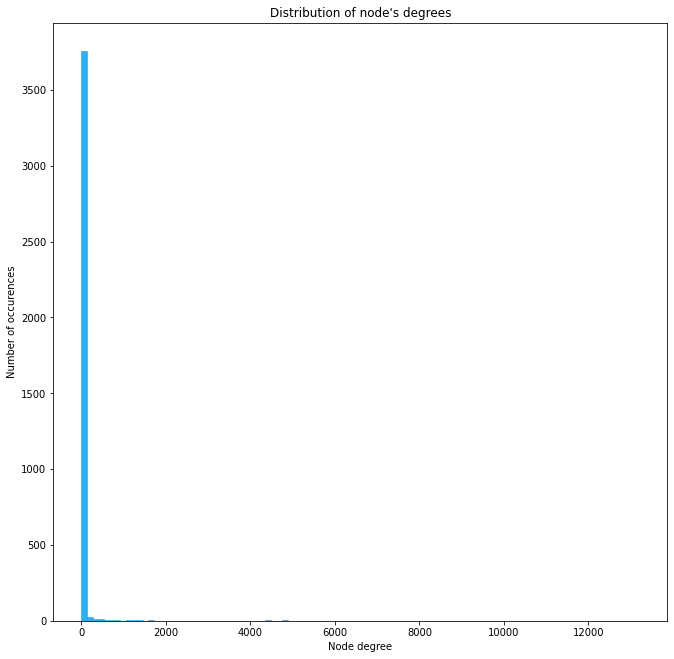

In [94]:
# We plot the distribution of the node's degrees.
plt.figure(figsize=(11,11))
plt.hist(nx.degree_histogram(G), log=False, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Node degree")
plt.ylabel("Number of occurences")
plt.title("Distribution of node's degrees")

Text(0.5, 1.0, "Distribution of node's degrees")

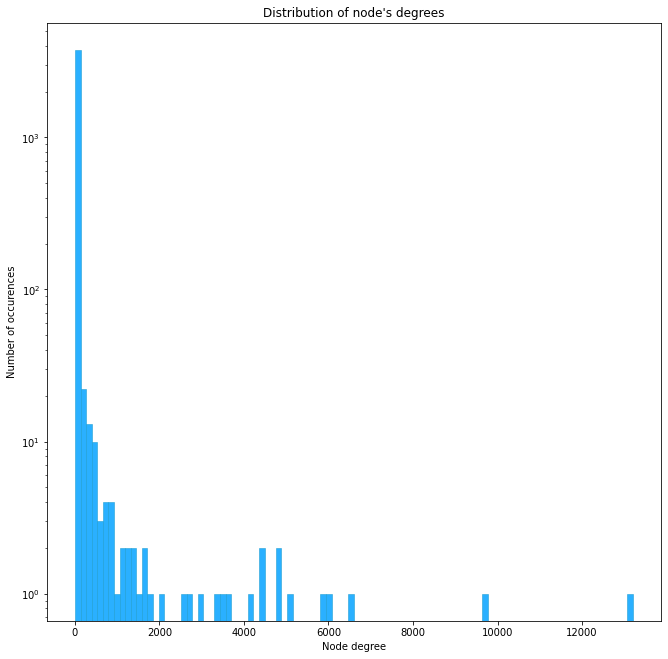

In [95]:
# We notice it looks like a heavy-tailed distribution so we apply a log-transform.
plt.figure(figsize=(11,11))
plt.hist(nx.degree_histogram(G), log=True, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Node degree")
plt.ylabel("Number of occurences")
plt.title("Distribution of node's degrees")

In [96]:
# We remove self-loop edges
G.remove_edges_from(nx.selfloop_edges(G))

In [97]:
len(G.nodes())

135761

In [98]:
G.size()

2084128

The graph we constructed has 135761 nodes and over 2,000,000 edges. We try to reduce the graph.

K-cores play an important role in revealing the higher-order organization of networks. So we apply this algorithm to obtain a graph that has a smaller number of nodes and edges.

In [99]:
G60 = nx.k_core(G, 60)

In [100]:
len(G60.nodes())

6490

(array([1.216e+03, 6.200e+01, 4.600e+01, 1.300e+01, 1.900e+01, 1.900e+01,
        9.000e+00, 1.100e+01, 1.600e+01, 5.000e+00, 4.000e+00, 7.000e+00,
        5.000e+00, 7.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 2.000e+00,
        5.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 5.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

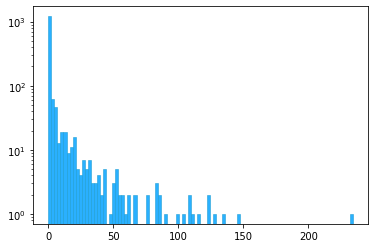

In [101]:
plt.hist(nx.degree_histogram(G60), log=True, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

We notice that we have a small group of very very connected nodes at the extreme right.

In [102]:
G100 = nx.k_core(G, 100)

In [103]:
nx.draw(G100)

TypeError: '_AxesStack' object is not callable

<Figure size 432x288 with 0 Axes>

Graph is still unreadable.

In [ ]:
plt.hist(nx.degree_histogram(G100), log=True, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

## Methods

### Step 1 : Co-stardom graphs

##### 1.A : **Actor-to-actor**
The way we are going to explore the data of this CMU repo augmented by some potentially other datasets, is first of all through building a co-stardom network. A costardom network is essentially a collaboration graph of film actors. The nodes represent movie star actors and two nodes are linked if the two-stars have starred in the same movie. We can add a weight to the link, the weight being the number of times two actors have performed together. This would be our first actor-to-actor graph.

##### 1.B : **Movie-to-movie**
We can similarly construct a movie-to-movie graph which could reveal interesting insights. In such a graph, a node would be a movie and two nodes would be linked if they share some of the cast members. If we deem it necessary, we can consider only the "important" people of the cast.

### Step 2 : Simplify and filter out nodes that are not necessary

##### 2.A Filter out the graph nodes below a certain degree and the graph edges below a certain weight


##### 2.B Create networks for Hollywood, Bollywood, and other countries

### Step 3 : Network analysis

##### 3.A : **Community detection**  
A network is said to have community structure if the nodes of the network can be easily grouped into (potentially overlapping) sets of nodes such that each set of nodes is densely connected internally. In the particular case of non-overlapping community finding, this implies that the network divides naturally into groups of nodes with dense connections internally and sparser connections between groups. A known algorithm to give us insights on this problem is the Girvan-Newman algorithm : it detects communities by progressively removing edges from the original network. The connected components of the remaining network are the communities    

##### 3.B: **Clustering based on actor attributes**  
The idea would be to use an algorithm that regroup actors with similar features we extracted and engineered in the preprocessing part.
The fact that actors have categorical features prevent us from using a K-means clustering as the Euclidean distance is not well
defined for categorical features. For this issue, we might use K-modes that mixes the Hamming distance for categorical data and Euclidean distance

In [119]:
character_meta[['freebase_actor_id', 'freebase_movie_id']].groupby('freebase_actor_id').apply(lambda x: list(x['freebase_movie_id']))

freebase_actor_id
/m/010p3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [/m/0bq2wj, /m/08hjr9, /m/06zm9p7, /m/06c5z_, /m/06c5z_, /m/0b6jfrc, /m/0fpm3d, /m/051wrdv, /m/047dv64, /m/03qk61v, /m/0ds67cb, /m/0kv065]
/m/010q36                                                                                                                                                                                                                                                                                                                                                         

In [121]:
character_meta['freebase_actor_id'].nunique()

135760

In [ ]:
# extract most prevalent genre of each actor 
# average movie revenue 
# clusterize data on those who have a character trope

### Step 4 : Build an ego network graph between actors

#### Ego network methematical description

Ego networks are network graphs were each individual node is an "ego". They allow us to describe and index the variation among individuals in the way they are embedded in "local" social structures.

Ego networks come with many definitions and related metrics (here the ones that are of interest to us): 

- Neighborhood is the collection of ego and all nodes/ties to whom ego has a connection at some path length (by neighborhood we usually imply path length of one). N-step neighborhood are neighborhoods up to path length N.
- In neighborhood includes all the actors with ties directly to ego.
- Out neighborhood includes all the actors with ties directed from ego

- Average geodesic distance is the mean of the shortest path lengths among all connected pairs in the ego network.
- Diameter of an ego network is the length of the longest path between connected actors
- Brokerage is number of pairs not directly connected. Normalized brokerage is brokerage divided by number of pairs
- Number of weak components, where a weak component is the biggest number of actors who are connected, not taking into account the direction of the ties.

- Two-step reach gives the percentage of all actors in the network that are within two directed steps of ego.  
- Reach efficiency is the two-step reach divided by its size.

- Brokerage is the number of pairs not directly connected. And the normalized brokerage is the brokerage divided by the number of pairs.

- Structural holes is the absence of ties between two parts of a network. They that help determine very important aspects of positional advantage/disadvantage of individuals that result from how they are embedded in neighborhoods. This helps to think about how and why the ways that an actor is connected affect its constraints and opportunities. 

#### Plan

- Describe and index the variation among actors in the way they are embedded in « local » social structures.

### Step 5 : Compute and visualize network metrics to highlight the power and influence of individuals

#### Metrics mathematical description

Graph metrics can be divided into 3 categories, the ones related to Connections, Distributions and Segmentation.

1) Connections

- Assortativity is the extent to which actors form ties with similar versus dissimilar others. This factor of similarity can be gender, race, age, status or any other characteristic.

- Multiplexity is a structural property of network ties that can give the existence of more than one type of relationship between two actors

- Propinquity describes the tendency for actors to have more ties with other actors that are close geographically.

2) Distributions

- Centrality

    - Betweenness centrality captures which nodes are important in the flow of the network. This by computing for every vertex the number of shortest paths that pass through it. The formula that computes it is the following :
    
    $$g(v)= \sum_{s \neq v \neq t}\frac{\sigma_{st}(v)}{\sigma_{st}}$$
    
        where sigma_{st} is the total number of shortest paths from node s to node t and sigma_{st}(v) is the number of those that pass through v.
        
    - Closeness centrality is the reciprocal of the sum of the length of the shortest paths between a given node and all other nodes in the graph. The more central a node is the closer it is to all other nodes.
    
    $$C_B(x)= \frac{1}{\sum_y d(y,x)}$$

        where d(y,x) is the distance (length of the shortest path) between vertices x and y.
        
    - Degree centrality counts how many edges each node has, hence the most degree central actor is the one with the most ties.

3) Segmentation

- Clustering coefficient measures the degree to which nodes in a graph tend to cluster together.

- Coehsion is the degree to which actors are connected directly to each other by cohesive bonds. Where cohesive bonds are bonds that link members of a social group to one another and to the group as a whole.

#### Plan

- Explore the existence of more than one type of relationship between two actors through computing multiplexity.
- Explore the tendency for actors to have more ties with other actors that are close geographically with propinquity.
- Determine positional advantages/disadvantages of individuals from structural holes. This will help to think abut how and why the ways that an actor is connected affect its constraints and opportunities.
- Understand which actors/directors/writers are the most important in the flow of the network, by computing betweenness/closeness/degree centrality.
- Compute to which degree actors/directors/writers tend to cluster together, computing the clustering coefficient.

### Step 6: Build website and redact datastory